<a href="https://colab.research.google.com/github/pras-4795/JPMCColab/blob/main/titanic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# About the dataset :

In [ ]:
#Read data
data = pd.read_csv('/content/drive/MyDrive/Dataset/titanic/train.csv')

#Printing first 5 rows
data[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


About the features :
- **PassengerId** : Id of each passsenger (in int)
- **Survived** : If survived or no (0 = No, 1 = Yes)
- **Pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **Name** : name (string)
- **Sex** : sex (string : 'male' 'female')
- **Age** : age in years
- **SibSp** : # of siblings / spouses aboard the Titanic
- **Parch** : # of parents / children aboard the Titanic
- **Ticket** : Ticket number (string)
- **Fare** : Passenger fare
- **Cabin** : Cabin number (string)
- **Embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Is the data imbalanced?

In [ ]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

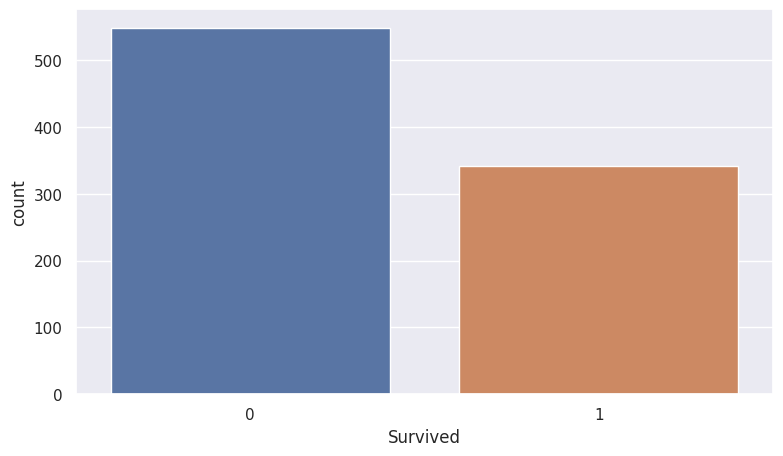

In [ ]:
sns.set()
sns.set(rc = {'figure.figsize':(9,5)})
sns.countplot(x="Survived",data=data)

- **Data is clearly imbalanced**, the count of people who survived **is almost close to half** the count of people who didn't survive

## Correlation with target variables

In [ ]:
data.corrwith(data["Survived"])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
dtype: float64

<BarContainer object of 7 artists>

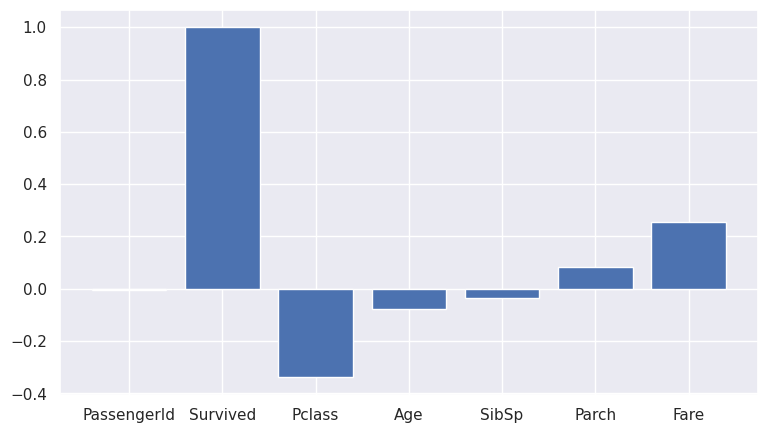

In [ ]:
plt.bar(dict(data.corrwith(data["Survived"])).keys(), dict(data.corrwith(data["Survived"])).values())

# Missing values?

In [ ]:
#Checking for Nan values in features excluding PassengerId, Name
print('Nan values exist in')
for col in [data.columns[i] for i in range(0, len(data.columns))]: #[1,2,4,5,6,7,8,9,10,11]]:
    print(col,':', any(data[col].isna()))

Nan values exist in
PassengerId : False
Survived : False
Pclass : False
Name : False
Sex : False
Age : True
SibSp : False
Parch : False
Ticket : False
Fare : False
Cabin : True
Embarked : True


- 'Age', 'Cabin' and 'Embarked' have Nan values. Lets check them further..

## Age

In [ ]:
data['Age'] = data['Age'].fillna('nan')

print(data[data['Age'] == 'nan']['Age'])

5      nan
17     nan
19     nan
26     nan
28     nan
      ... 
859    nan
863    nan
868    nan
878    nan
888    nan
Name: Age, Length: 177, dtype: object


- There are 177 Nan values in the Age column

- Now, we impute the missing values with a central tendency measure (median performed the best in this case)

In [ ]:
def impute_missing_data(test, col, median, mode):
    if col in test :
        test[col] = test[col].fillna('nan')

        test_feature = test.drop(test[test[col]== 'nan'].index, axis= 0)[col]

        nan_index = test[test[col]== 'nan'].index

        for i in nan_index:
            if median == True:
                test[col].iloc[i] = test_feature.median()
            elif mode == True:
                test[col].iloc[i] = test_feature.value_counts().index[0]

    return test

In [ ]:
#Imputing mean values for missing data
data = impute_missing_data(data, 'Age', median =True, mode=False)

In [ ]:
any(data['Age'].isna())

False

In [ ]:
data['Age'] = data['Age'].map(lambda x: int(x))

In [ ]:
'''data = data.drop(data[data['Age']== 'nan'].index, axis= 0)
data.info()'''

"data = data.drop(data[data['Age']== 'nan'].index, axis= 0)\ndata.info()"

In [ ]:
data.corrwith(data["Survived"])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.064909
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
dtype: float64

## Cabin

In [ ]:
data['Cabin'] = data['Cabin'].fillna('nan')

print(data[data['Cabin'] == 'nan']['Cabin'])

0      nan
2      nan
4      nan
5      nan
7      nan
      ... 
884    nan
885    nan
886    nan
888    nan
890    nan
Name: Cabin, Length: 687, dtype: object


- Since 'Cabin' has around 529 nan values which is more than 50 percent of the total data, we drop this feature

In [ ]:
data['cabin_nan'] = [1 if data['Cabin'].iloc[i] =='nan' else 0 for i in range(len(data))]
#data['cabin_val'] = [0 if data['Cabin'].iloc[i] =='nan' else 1 for i in range(len(data))]


## Embarked

In [ ]:
data['Embarked'] = data['Embarked'].fillna('nan')

print(data[data['Embarked'] == 'nan']['Embarked'])

61     nan
829    nan
Name: Embarked, dtype: object


- Only two nan values, we impute them with the maximum occuring category for the feature or the mode

In [ ]:
#Imputing the mode values for missing data
data = impute_missing_data(data, 'Embarked', median = False, mode = True)

In [ ]:
any(data['Embarked'].isna())

False

In [ ]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,0


In [ ]:
data.corrwith(data["Survived"])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.064909
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
cabin_nan     -0.316912
dtype: float64

<BarContainer object of 8 artists>

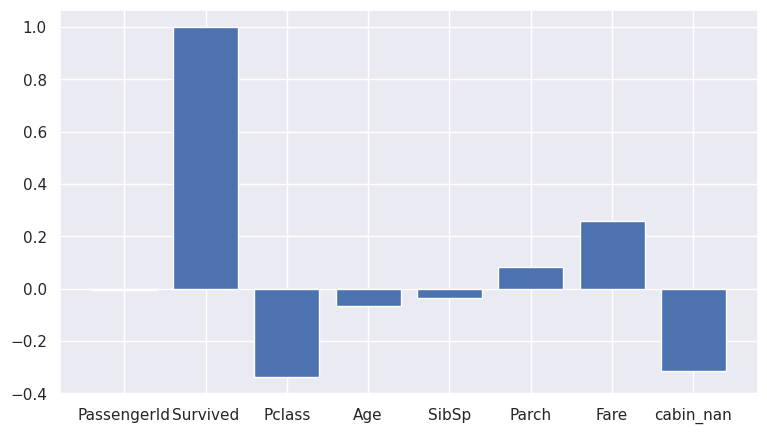

In [ ]:
plt.bar(dict(data.corrwith(data["Survived"])).keys(), dict(data.corrwith(data["Survived"])).values())

# EDA

## Age of the people who survived?

Three visualizations :
1. Boxplots : To tell us about the distribution of the feature for each output class and give us an idea about the outliers in the data
2. Density plots : To tell us about the distribution and more about the shape of the distribution (resembling normal or any other disb) of the feature
3. Stacked countplots : Tells us more about count of each category of the feature with information about the percentage belonging to which output class

Text(0.5, 1.0, 'Density plot')

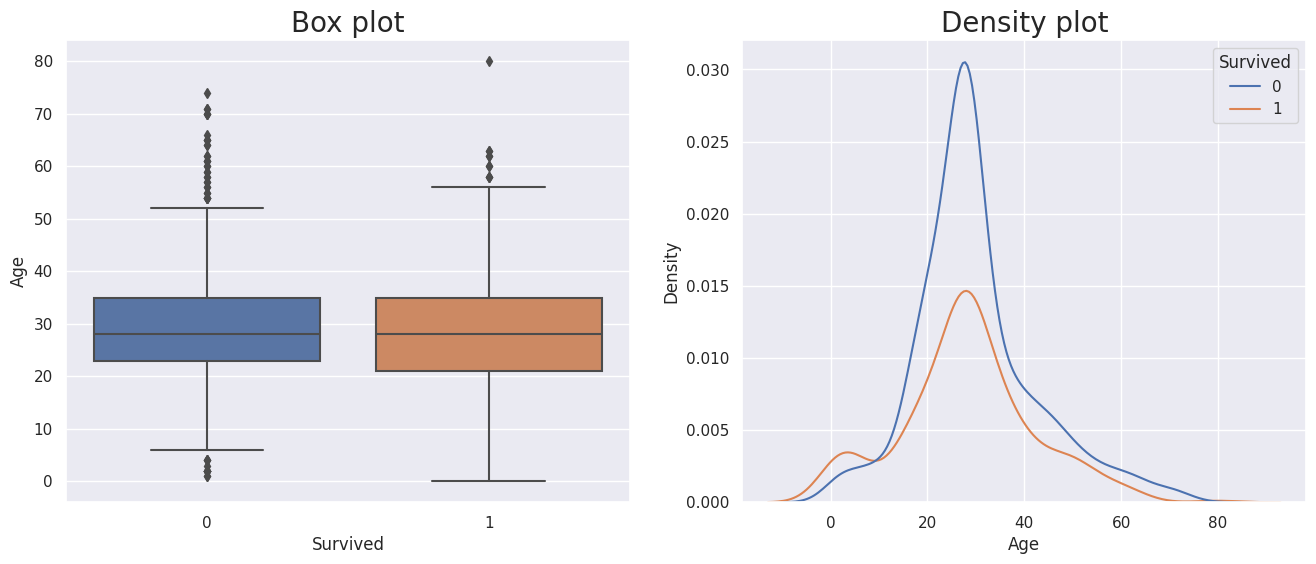

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Age", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Age', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

- Distribution of people who didn't survive is slightly right skewed, or the mean of the people who did not survive > median of the distribution which is around ~27, i.e. **mean age of the people who did not survive is higher than 27**
- People of ages > ~67 are considered outliers in the disb of people who did not survive. owing to the fact **people above the age of ~67 are very less** and people of age ~60 above are outliers in the disb of people who did survive, i.e. **very few people above 60 actually did survive**

In [ ]:
def plot_stacked_plot_percentages(class_list, df_p, add_x_val):

    '''This function adds the percentage in each stacked plot
    class_list : contains three params, count of each rect/class, total for that rect/class, ax object of that rect/class
    df_p : df.axes.patches object for each rectange
    add_x_val : x axis value to center the text
    '''

    for class_val in class_list:

        percentage = (class_val[0]/class_val[1])*100
        height = class_val[2].get_height()
        df_p.axes.text(class_val[2].get_x()+add_x_val, height,"{:1.1f}%".format(percentage))

In [ ]:
def calculate_stacked_plot_percentages(df_plot, df_p):
    #Find the counts for each age bin for calcualting percentage
    df_plot_sum = df_plot.sum(axis=1)
    class_sum = np.array([df_plot_sum.iloc[int(i/2)] if i%2==0 else df_plot_sum.iloc[int((i-1)/2)] for i in range(2*len(df_plot_sum)) ]).reshape((len(df_plot_sum),2)).T.flatten()
    class_list = zip(np.roll(df_plot.to_numpy().T.flatten(), len(df_plot)), class_sum, list(df_p.axes.patches))

    return class_list

Survived        0    1
age_bin               
(-0.1, 27.0]  189  130
(27.0, 53.0]  326  196
(53.0, 80.0]   34   16


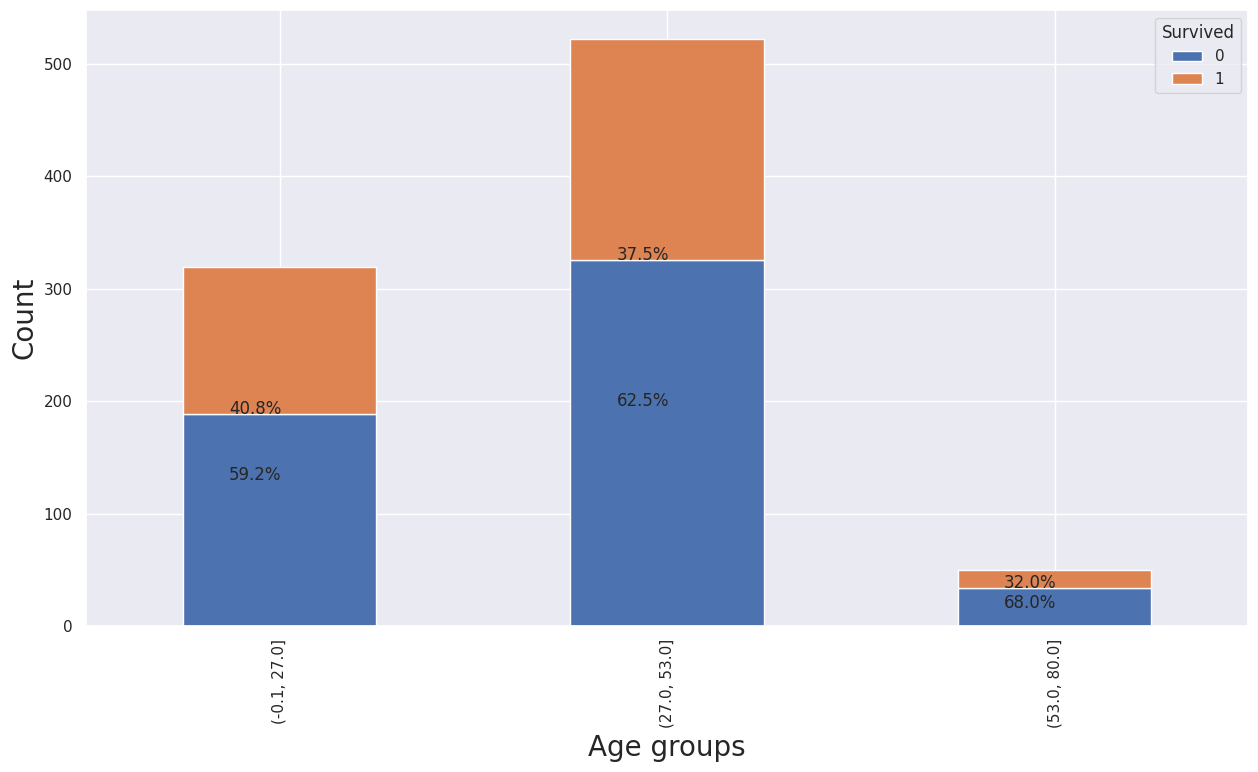

In [ ]:
#Stacked countplot : https://stackoverflow.com/questions/50319614/count-plot-with-stacked-bars-per-hue #Add percentages on stacked countplots : https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
sns.set(rc = {'figure.figsize':(15,8)})

#Find the bins
data['age_bin'] = pd.cut(data['Age'], 3, precision = 0)

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'age_bin']).size().reset_index().pivot(columns='Survived', index='age_bin', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Age groups", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.12)

- In the above stacked plots, the age has been binned into 3 age bins, Bin1 or the younger people in age group 0-27 years, Bin 2 or the iddle aged in age group 27-53 years, and Bin3 or the older people in age group 53 -80 years
- Majority of people fall in age bin Bin 1 [0-27], and Bin 2 [27 - 53] while a minority fall in Bin3 [53-80]
- The percentage of people who survived is **slightly lower in Bin 1 and Bin 2** (40.8 and 37.5 % respectively), while the **percentage of people who survived is much lower in Bin 3 (32%)**

Note : Countplots vs box plots

In [ ]:
#how to drop outliers from data after analysing with boxplot : https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
def drop_outliers(data , col):
    Q1 = data['Age'].quantile(0.25)
    Q3 = data['Age'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.

    filter = (data['Age'] >= Q1 - 1.5 * IQR) & (data['Age'] <= Q3 + 1.5 *IQR) #filter filters out data within Q1 - 1.5*IQR to Q3 + 1.5*IQR
    data = data.loc[filter]
    return data

In [ ]:
#data = drop_outliers(data , 'Age')
#data

- We have 825 rows now that 66 rows containing age outliers were removed

## Sex of the surviors ?

Survived    0    1
Sex               
female     81  233
male      468  109


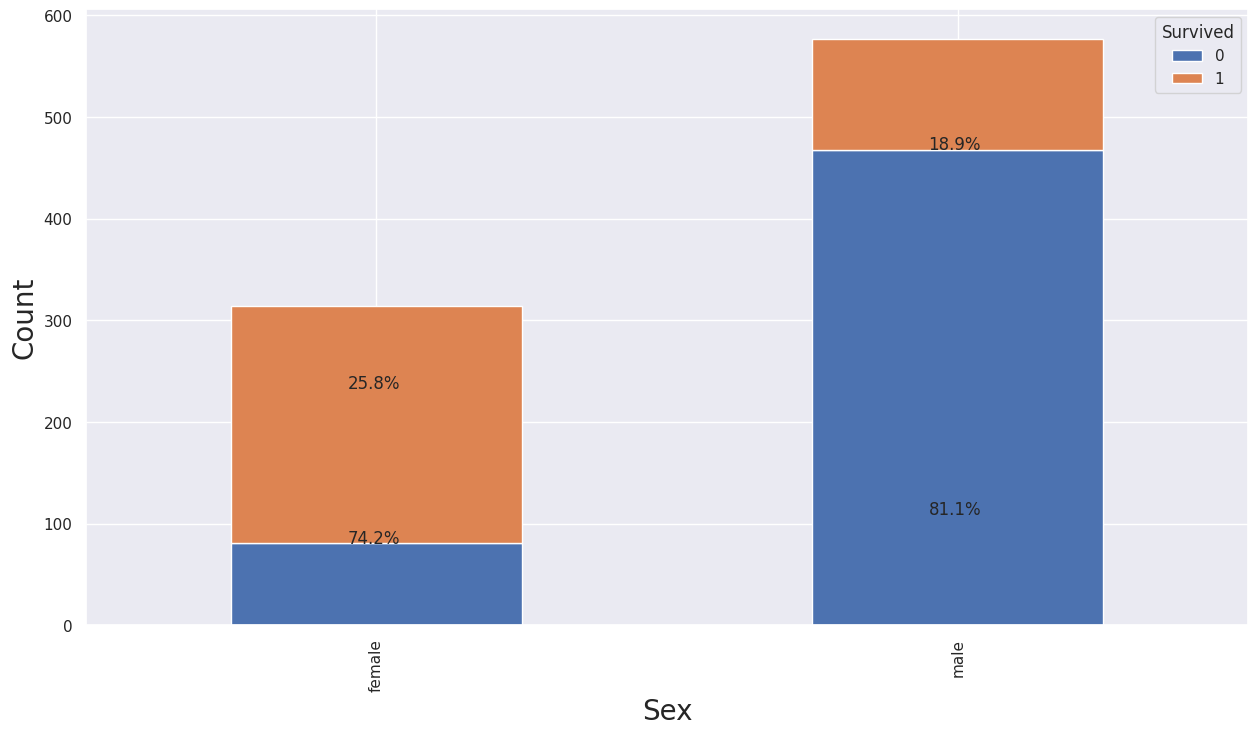

In [ ]:
#Stacked countplot : https://stackoverflow.com/questions/50319614/count-plot-with-stacked-bars-per-hue #Add percentages on stacked countplots : https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Sex", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.2)

- From the above stacked plots, it is clear **more percentage of female passengers survived** i.e. 74.2 % while only 18.9 % of male passengers survived, even though more male passesngers were aboard

In [ ]:
'''sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Sex", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Sex', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)'''

'sns.set(rc = {\'figure.figsize\':(16,6)})\nplt.plot(figure_size = (1,2))\n\n#Boxplots\nplt.subplot(1,2,1)\nbp_ax = sns.boxplot(x = "Survived",y="Sex", data = data)\nbp_ax.set_title(\'Box plot\', fontsize = 20)\n\n#Density plots\nplt.subplot(1,2,2)\ndp_ax = sns.kdeplot(x = \'Sex\', hue = \'Survived\', data = data)\ndp_ax.set_title(\'Density plot\', fontsize = 20)'

In [ ]:
#data = drop_outliers(data , 'Sex')
#data

## Fares of the survivors?

Text(0.5, 1.0, 'Density plot')

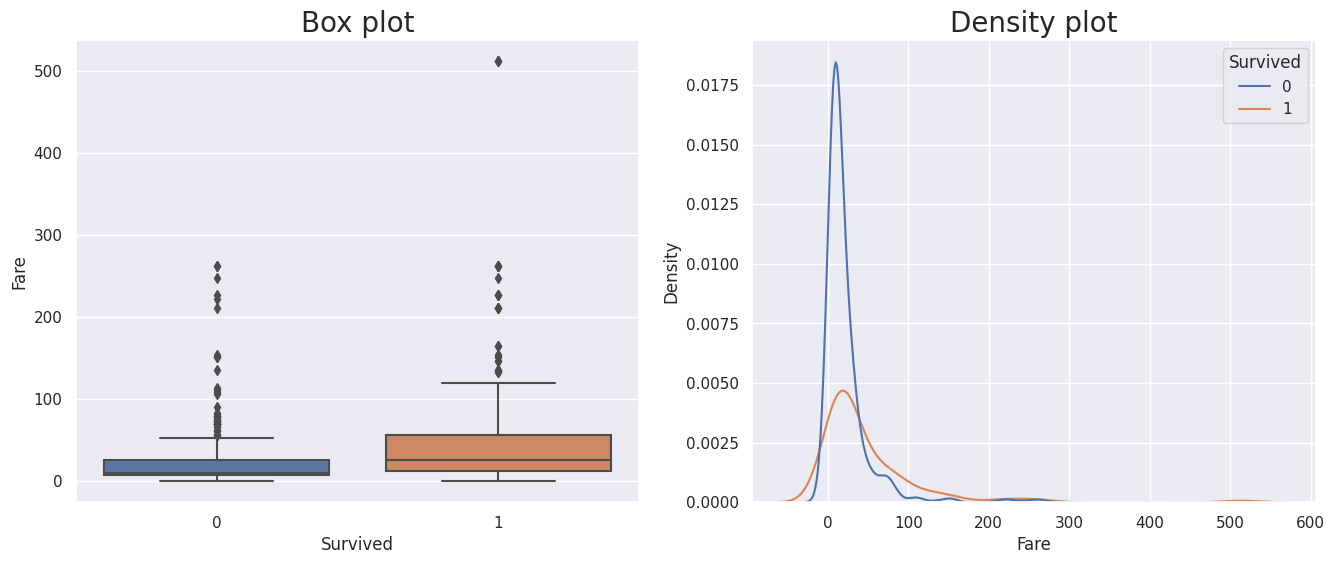

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Fare", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Fare', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

- Distribution of fares of survivors clearly has a higher median value, hence **passengers who survived had higher average fares**
- Lots of outliers in the distribution of both
- A huge spike in the pdf of the people who didn't survive, or the probability that the person who didn't survive had a fare of ~10 units of currency is very high

In [ ]:
#data = drop_outliers(data , 'Fare')
#data

### Converting fares into categorical variables

In [ ]:
def fares_categorical(data):
    data['fare_bin'] = pd.cut(data['Fare'], 3, precision = 0)
    return data

data = fares_categorical(data)
map_obj = {(-1.0, 171.0) : 0, (171.0, 342.0): 1,(342.0, 512.0):2}
data['fare_bin'] = data['fare_bin'].map(lambda x: map_obj[(x.left, x.right)])

Text(0.5, 1.0, 'Box plot')

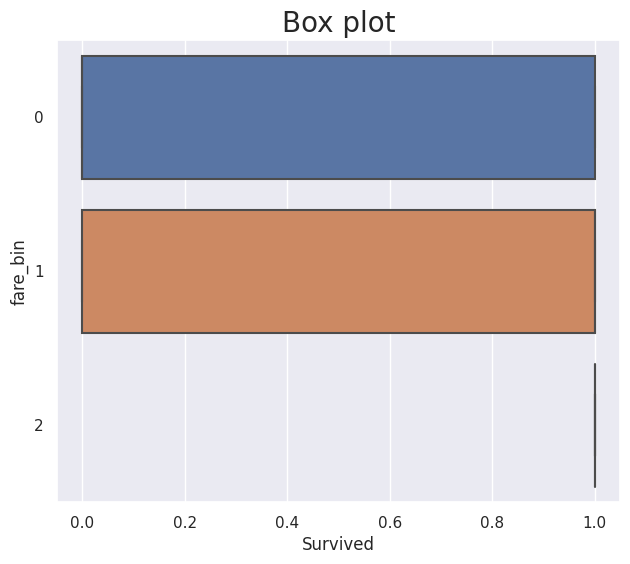

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="fare_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
#plt.subplot(1,2,2)
#dp_ax = sns.kdeplot(x = 'fare_bin', hue = 'Survived', data = data)
#dp_ax.set_title('Density plot', fontsize = 20)

## Port embarked of survivors?

Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219


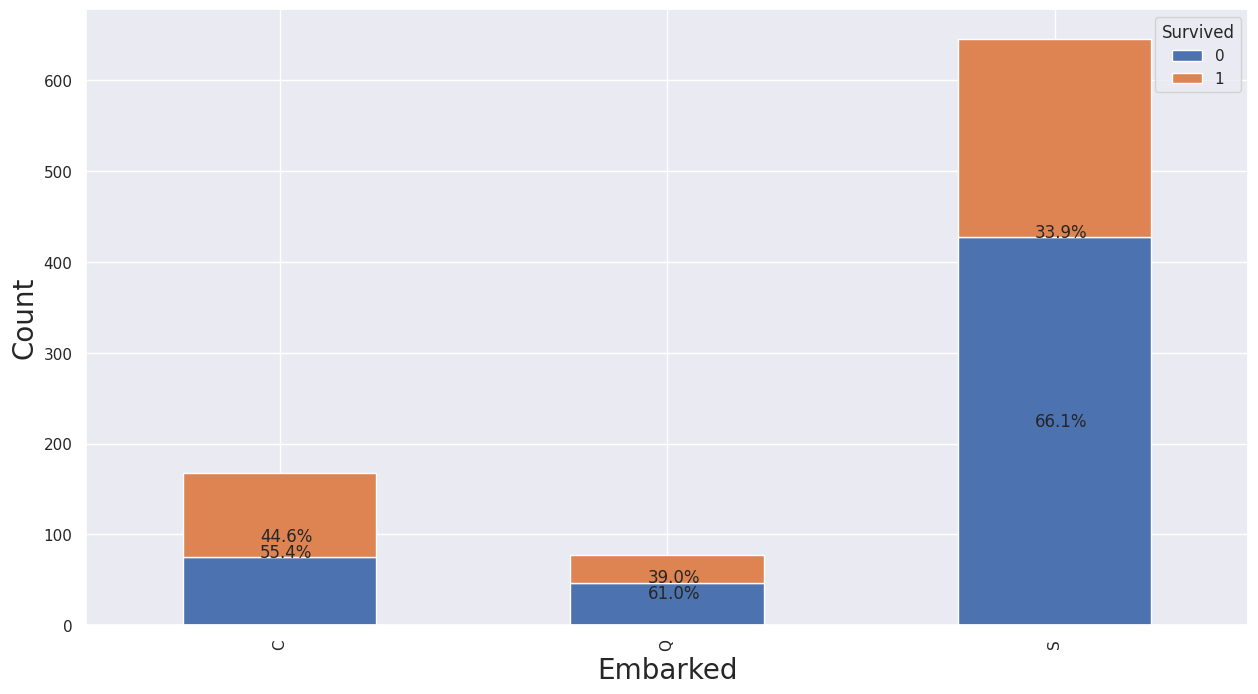

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Embarked']).size().reset_index().pivot(columns='Survived', index='Embarked', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Embarked", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.2)

In [ ]:
'''sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Embarked", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Embarked', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)'''

'sns.set(rc = {\'figure.figsize\':(16,6)})\nplt.plot(figure_size = (1,2))\n\n#Boxplots\nplt.subplot(1,2,1)\nbp_ax = sns.boxplot(x = "Survived",y="Embarked", data = data)\nbp_ax.set_title(\'Box plot\', fontsize = 20)\n\n#Density plots\nplt.subplot(1,2,2)\ndp_ax = sns.kdeplot(x = \'Embarked\', hue = \'Survived\', data = data)\ndp_ax.set_title(\'Density plot\', fontsize = 20)'

## Name of the survivors

### Name title

In [ ]:
data['Name'].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [ ]:
data_name_title_1 = data[data['Name'].str.contains('Miss')]['Name']
data_name_title_2 = data[data['Name'].str.contains('Mrs')]['Name']
data_name_title_3 = data[data['Name'].str.contains('Master')]['Name']
data_name_title_4 = data[data['Name'].str.contains('Mr')]['Name']
data_name_title_5 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']

In [ ]:
data_name_title_5.value_counts()

Uruchurtu, Don. Manuel E                                    1
Byles, Rev. Thomas Roussel Davids                           1
Harper, Rev. John                                           1
Reuchlin, Jonkheer. John George                             1
Leader, Dr. Alice (Farnham)                                 1
Brewe, Dr. Arthur Jackson                                   1
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)    1
Crosby, Capt. Edward Gifford                                1
Weir, Col. John                                             1
Frauenthal, Dr. Henry William                               1
Simonius-Blumer, Col. Oberst Alfons                         1
Sagesser, Mlle. Emma                                        1
Stahelin-Maeglin, Dr. Max                                   1
Kirkland, Rev. Charles Leonard                              1
Butt, Major. Archibald Willingham                           1
Peuchen, Major. Arthur Godfrey                              1
Reynaldo

In [ ]:
def name_encoding(data):
    data['name_title'] = [np.nan for i in range(len(data))]

    data_name_title_1 = data[data['Name'].str.contains('Miss')]['Name']
    data_name_title_2 = data[data['Name'].str.contains('Mrs')]['Name']
    data_name_title_3 = data[data['Name'].str.contains('Master')]['Name']
    data_name_title_4 = data[data['Name'].str.contains('Mr')]['Name']
    data_name_title_5 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']

    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_name_title_1):
            data['name_title'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_name_title_2):
            data['name_title'].iloc[i] = 1
        elif data['Name'].iloc[i] in list(data_name_title_3):
            data['name_title'].iloc[i] = 2
        elif data['Name'].iloc[i] in list(data_name_title_4):
            data['name_title'].iloc[i] = 3
        elif data['Name'].iloc[i] in list(data_name_title_5):
            data['name_title'].iloc[i] = 4

    return data

In [ ]:
data = name_encoding(data)

In [ ]:
data['name_title'].value_counts()

3.0    518
0.0    182
1.0    127
2.0     40
4.0     24
Name: name_title, dtype: int64

Survived      0    1
name_title          
0.0          55  127
1.0          26  101
2.0          17   23
3.0         436   82
4.0          15    9


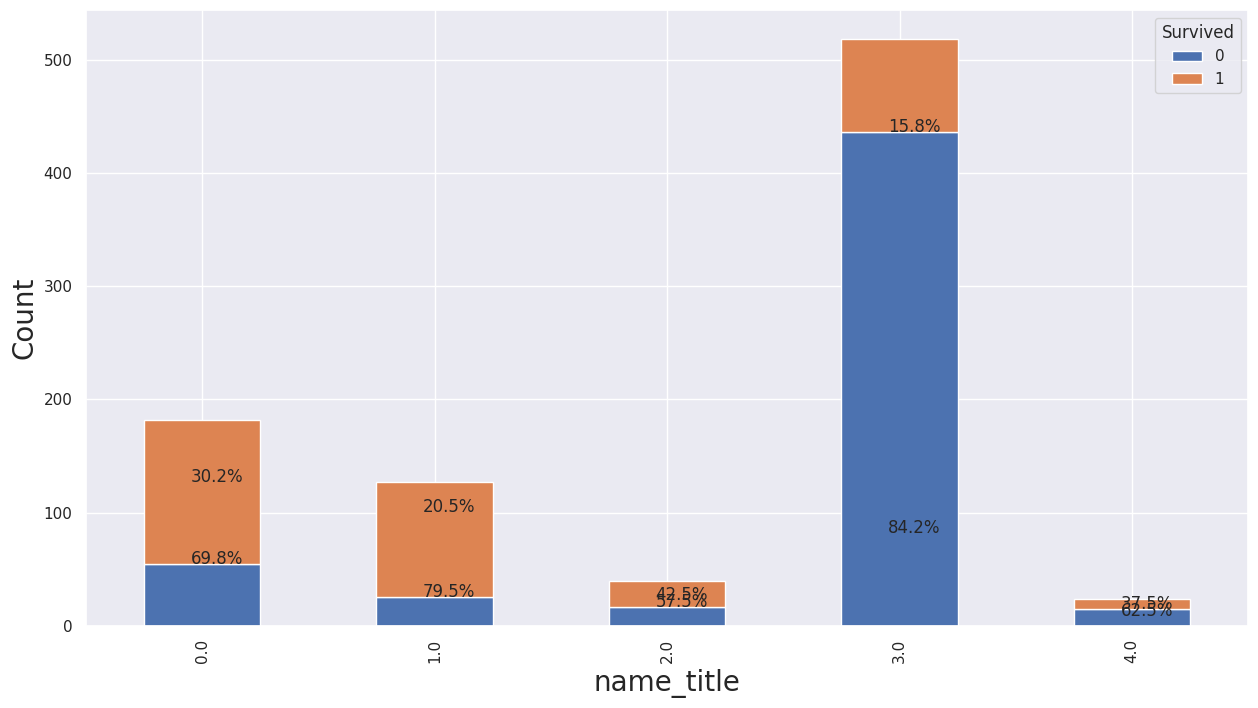

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'name_title']).size().reset_index().pivot(columns='Survived', index='name_title', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("name_title", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.2)

Text(0.5, 1.0, 'Density plot')

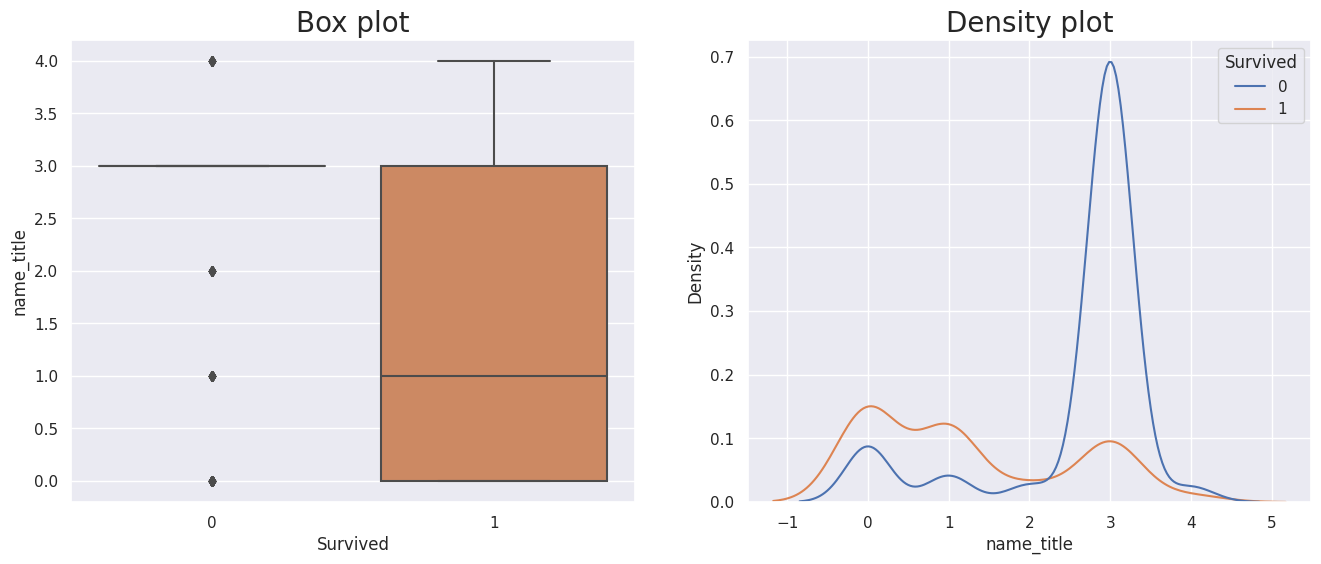

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="name_title", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'name_title', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

### Name title (without m/f)

In [ ]:
data_name_title_1 = data[data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master')]['Name']
data_name_title_2 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']

In [ ]:
data_name_title_2.value_counts()

Uruchurtu, Don. Manuel E                                    1
Byles, Rev. Thomas Roussel Davids                           1
Harper, Rev. John                                           1
Reuchlin, Jonkheer. John George                             1
Leader, Dr. Alice (Farnham)                                 1
Brewe, Dr. Arthur Jackson                                   1
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)    1
Crosby, Capt. Edward Gifford                                1
Weir, Col. John                                             1
Frauenthal, Dr. Henry William                               1
Simonius-Blumer, Col. Oberst Alfons                         1
Sagesser, Mlle. Emma                                        1
Stahelin-Maeglin, Dr. Max                                   1
Kirkland, Rev. Charles Leonard                              1
Butt, Major. Archibald Willingham                           1
Peuchen, Major. Arthur Godfrey                              1
Reynaldo

In [ ]:
def name_encoding_1(data):
    data['name_title_1'] = [np.nan for i in range(len(data))]
    data_name_title_1 = data[data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master')]['Name']
    data_name_title_2 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']
    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_name_title_1):
            data['name_title_1'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_name_title_2):
            data['name_title_1'].iloc[i] = 1

    return data

In [ ]:
data = name_encoding_1(data)

Text(0.5, 1.0, 'Density plot')

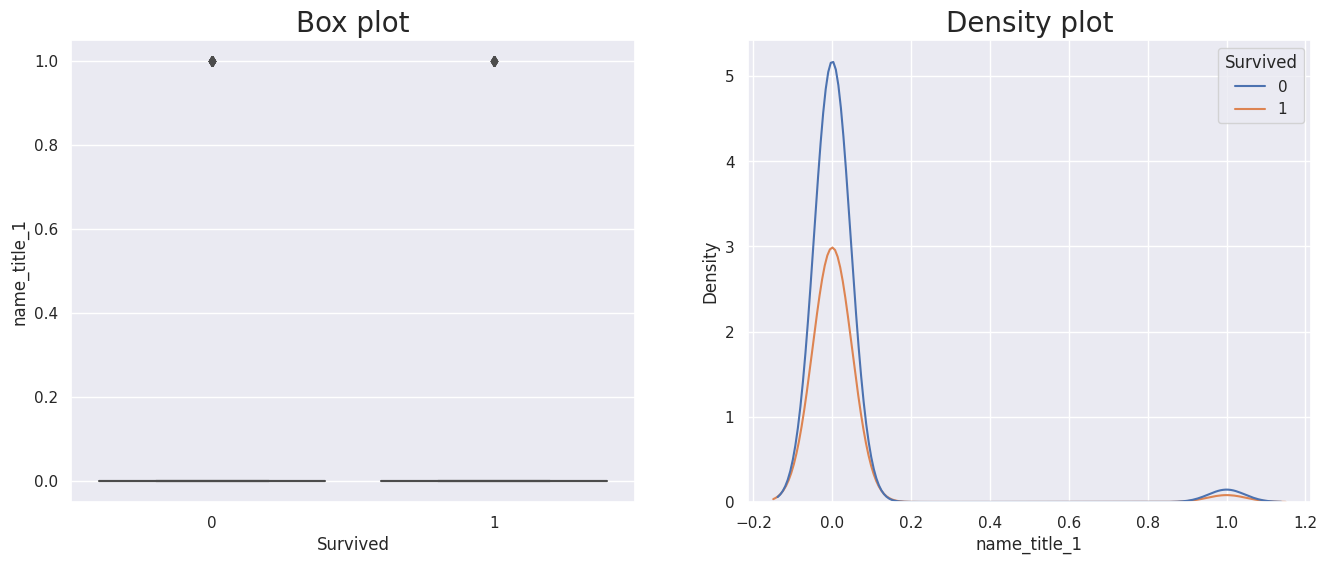

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="name_title_1", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'name_title_1', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

### Name length

In [ ]:
data['name_length'] = data['Name'].map(lambda x: len(str(x)))

Text(0.5, 1.0, 'Density plot')

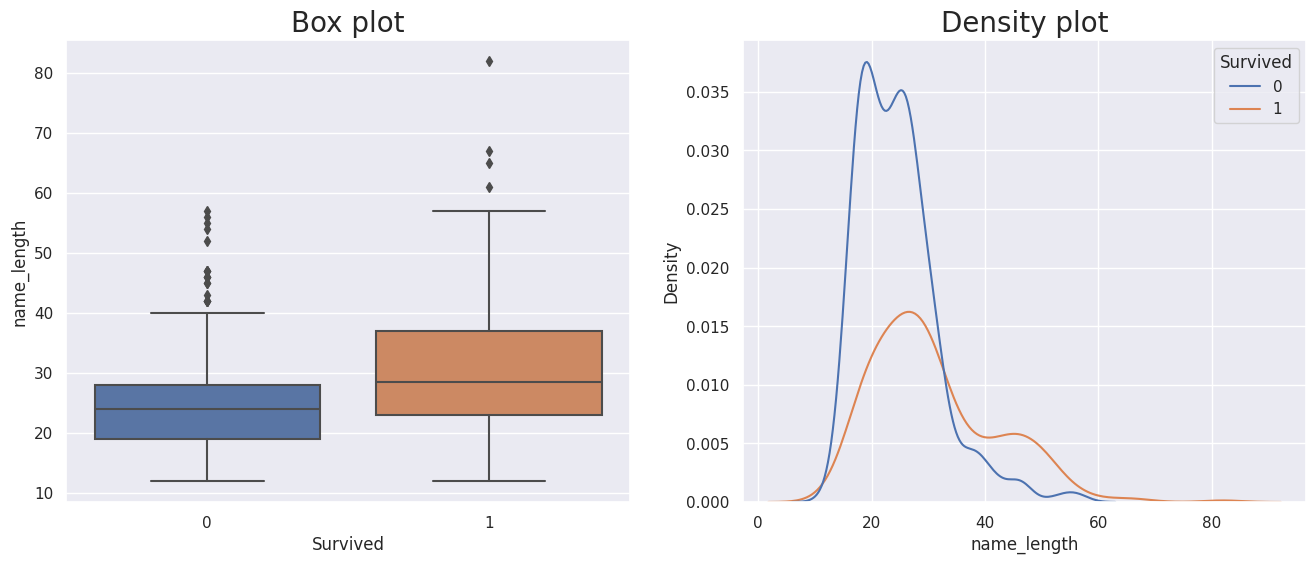

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="name_length", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'name_length', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

In [ ]:
def name_length_categorical(data):
    data['name_length_bin'] = pd.cut(data['name_length'], 3, precision = 0)
    return data

In [ ]:
data = name_length_categorical(data)
data['name_length_bin'].value_counts().keys()[1]

Interval(35.0, 59.0, closed='right')

In [ ]:
map_obj = {(data['name_length_bin'].value_counts().keys()[0].left, data['name_length_bin'].value_counts().keys()[0].right) : 0, (data['name_length_bin'].value_counts().keys()[1].left, data['name_length_bin'].value_counts().keys()[1].right): 1,(data['name_length_bin'].value_counts().keys()[2].left, data['name_length_bin'].value_counts().keys()[2].right):2}
data['name_length_bin'] = data['name_length_bin'].map(lambda x: map_obj[(x.left, x.right)])

### Name vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
'''
vectorizer = CountVectorizer()
X1 = vectorizer.fit_transform(data['Name'])
data_name_vectorized = pd.DataFrame(data['Name'].map(lambda x : X1.toarray()[list(data['Name']).index(x)]))'''

"\nvectorizer = CountVectorizer()\nX1 = vectorizer.fit_transform(data['Name'])\ndata_name_vectorized = pd.DataFrame(data['Name'].map(lambda x : X1.toarray()[list(data['Name']).index(x)]))"

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/titanic/test.csv')
test_name = test['Name']
name_list = pd.concat([test_name, data['Name']], axis = 0)

In [ ]:
#Reference : https://www.kaggle.com/slythe/infamous-titanic-80-accuracy
vectorizer = CountVectorizer()
name_v = vectorizer.fit(name_list)

In [ ]:
def name_vectorizer(data):
    if 'Name' in data.columns:
        #data['name_vectorized'] = data['Name'].map(lambda x : X1.toarray()[list(data['Name']).index(x)].sum())
        name_v = vectorizer.transform(data["Name"])
        name_vector_df = pd.DataFrame(data = name_v.todense(), columns = vectorizer.get_feature_names())
        data = pd.concat([data,name_vector_df], axis =1 )
    return data

In [ ]:
#data = name_vectorizer(data)

In [ ]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_nan,age_bin,fare_bin,name_title,name_title_1,name_length,name_length_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S,1,"(-0.1, 27.0]",0,3.0,0.0,23,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,0,"(27.0, 53.0]",0,1.0,0.0,51,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S,1,"(-0.1, 27.0]",0,0.0,0.0,22,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,0,"(27.0, 53.0]",0,1.0,0.0,44,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S,1,"(27.0, 53.0]",0,3.0,0.0,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S,1,"(27.0, 53.0]",0,4.0,1.0,21,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,0,"(-0.1, 27.0]",0,0.0,0.0,28,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S,1,"(27.0, 53.0]",0,0.0,0.0,40,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,0,"(-0.1, 27.0]",0,3.0,0.0,21,0


In [ ]:
'''sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="name_vectorized", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'name_vectorized', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)'''

'sns.set(rc = {\'figure.figsize\':(16,6)})\nplt.plot(figure_size = (1,2))\n\n#Boxplots\nplt.subplot(1,2,1)\nbp_ax = sns.boxplot(x = "Survived",y="name_vectorized", data = data)\nbp_ax.set_title(\'Box plot\', fontsize = 20)\n\n#Density plots\nplt.subplot(1,2,2)\ndp_ax = sns.kdeplot(x = \'name_vectorized\', hue = \'Survived\', data = data)\ndp_ax.set_title(\'Density plot\', fontsize = 20)'

## Letter of surname

In [ ]:
data['Name'].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [ ]:
highest = {}
for letter in ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]:
    data_name_1 = data['Name'][data['Name'].str.startswith(letter)]
    highest[letter] = len(data_name_1)

In [ ]:
highest = sorted(highest.items(), key = lambda x:x[1], reverse = True)
print('Maximum occurence of letters in surname beginning :',highest[:5])

Maximum occurence of letters in surname beginning : [('S', 86), ('M', 74), ('B', 72), ('C', 69), ('H', 69)]


In [ ]:
def surname_encoding(data):
    data['surname'] = [np.nan for i in range(len(data))]

    data_surname_1 = data['Name'][data['Name'].str.startswith("S")]
    data_surname_2 = data['Name'][data['Name'].str.startswith("M")]
    data_surname_3 = data['Name'][data['Name'].str.startswith("B")]
    data_surname_4 = data['Name'][data['Name'].str.startswith("C")]
    data_surname_5 = data['Name'][data['Name'].str.startswith("H")]
    data_surname_6 = data['Name'][~ (data['Name'].str.startswith("S") | data['Name'].str.startswith("M") | data['Name'].str.startswith("B")| data['Name'].str.startswith("C")| data['Name'].str.startswith("H"))]

    for i in range(len(data)):
        if data['Name'].iloc[i] in list(data_surname_1):
            data['surname'].iloc[i] = 0
        elif data['Name'].iloc[i] in list(data_surname_2):
            data['surname'].iloc[i] = 1
        elif data['Name'].iloc[i] in list(data_surname_3):
            data['surname'].iloc[i] = 2
        elif data['Name'].iloc[i] in list(data_surname_4):
            data['surname'].iloc[i] = 3
        elif data['Name'].iloc[i] in list(data_surname_5):
            data['surname'].iloc[i] = 4
        elif data['Name'].iloc[i] in list(data_surname_6):
            data['surname'].iloc[i] = 5


    return data

In [ ]:
data = surname_encoding(data)

Text(0.5, 1.0, 'Density plot')

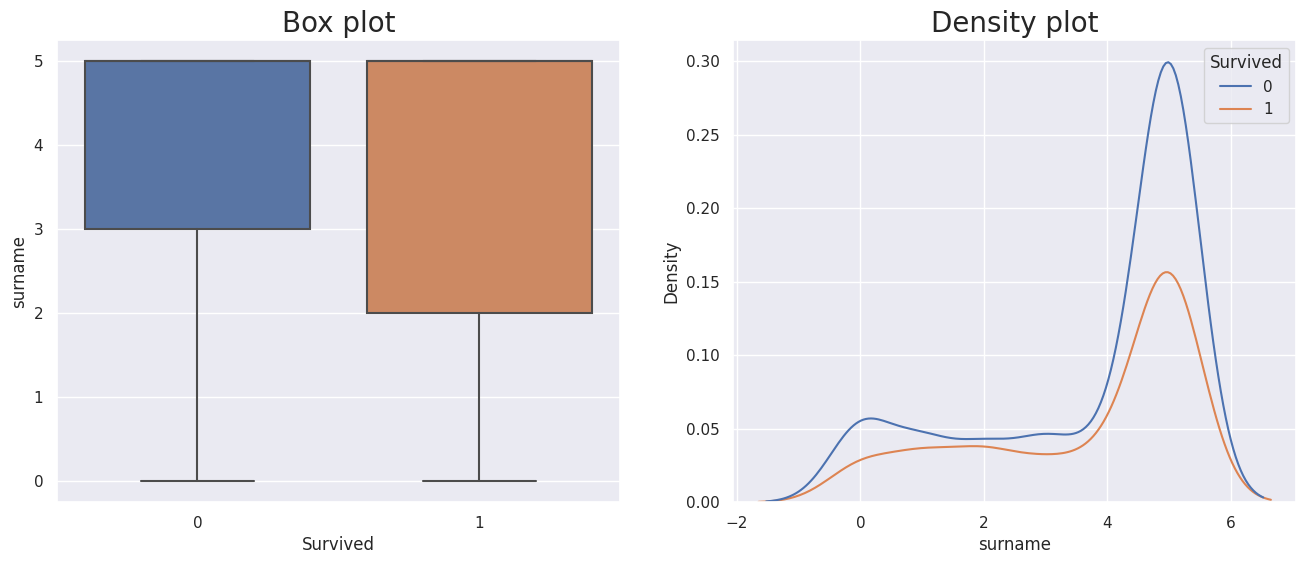

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="surname", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'surname', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

## Tickets of survivors?

In [ ]:
data['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- There are a total of 681 different ticket types.
- For starters, lets try to form categories based on the the presence of a digit in the string

In [ ]:
data_ticket_1 = data[data['Ticket'].str.isdigit() == True]['Ticket']
print(data_ticket_1)

3      113803
4      373450
5      330877
6       17463
7      349909
        ...  
885    382652
886    211536
887    112053
889    111369
890    370376
Name: Ticket, Length: 661, dtype: object


- There are 661 tickets that contain only numbers

In [ ]:
data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
print(data_ticket_2.value_counts())

CA. 2343              7
CA 2144               6
S.O.C. 14879          5
PC 17757              4
LINE                  4
                     ..
F.C.C. 13528          1
SOTON/O.Q. 3101311    1
A/5 3540              1
PC 17610              1
SOTON/OQ 392076       1
Name: Ticket, Length: 167, dtype: int64


- There are 167 tickets that contain a string plus numbers. For these, we categorise them based on the letter the ticket name starts with, namely 'C', 'P' and 'S' since these are the most common

In [ ]:
data_ticket_2_1 = data_ticket_2[data_ticket_2.str.startswith("C")]
print(data_ticket_2_1, len(data_ticket_2_1))

33           C.A. 24579
56           C.A. 31026
58           C.A. 34651
59              CA 2144
66           C.A. 29395
70           C.A. 33111
71              CA 2144
93            C.A. 2315
127             C 17369
134          C.A. 29178
145          C.A. 33112
159            CA. 2343
161          C.A. 33595
180            CA. 2343
201            CA. 2343
234          C.A. 29566
237          C.A. 31921
265          C.A. 17248
279           C.A. 2673
324            CA. 2343
348          C.A. 37671
365              C 7076
376              C 7077
386             CA 2144
439          C.A. 18723
450          C.A. 34651
472          C.A. 34651
480             CA 2144
489          C.A. 37671
497           C.A. 6212
508              C 4001
516          C.A. 34260
549          C.A. 33112
637          C.A. 31921
649            CA. 2314
672          C.A. 24580
678             CA 2144
683             CA 2144
746           C.A. 2673
788           C.A. 2315
792            CA. 2343
801          C.A

In [ ]:
data_ticket_2_2 = data_ticket_2[data_ticket_2.str.startswith("S")]
print(data_ticket_2_2, len(data_ticket_2_2))

2      STON/O2. 3101282
43        SC/Paris 2123
45      S.C./A.4. 23567
67            S.P. 3464
72         S.O.C. 14879
             ...       
827     S.C./PARIS 2079
840    SOTON/O2 3101287
841         S.O./P.P. 3
866       SC/PARIS 2149
884     SOTON/OQ 392076
Name: Ticket, Length: 65, dtype: object 65


In [ ]:
data_ticket_2_3 = data_ticket_2[data_ticket_2.str.startswith("P")]
print(data_ticket_2_3, len(data_ticket_2_3))

1       PC 17599
10       PP 9549
30      PC 17601
31      PC 17569
34      PC 17604
         ...    
793     PC 17600
835     PC 17756
853     PC 17592
867     PC 17590
874    P/PP 3381
Name: Ticket, Length: 65, dtype: object 65


In [ ]:
data_ticket_2_4 = data_ticket_2[~ (data_ticket_2.str.startswith("C") | data_ticket_2.str.startswith("S") | data_ticket_2.str.startswith("P"))]
print(data_ticket_2_4, len(data_ticket_2_4))

0         A/5 21171
12        A/5. 2151
37       A./5. 2152
51       A/4. 39886
86       W./C. 6608
92      W.E.P. 5734
121       A4. 54510
132       A/5. 3337
147      W./C. 6608
152      A.5. 11206
153        A/5. 851
154       Fa 265302
179            LINE
204        A/5 3540
211    F.C.C. 13528
212       A/5 21174
219       W/C 14208
227       A/5 21173
235      W./C. 6609
242     W./C. 14263
253       A/5. 3336
271            LINE
283      A/5. 10482
302            LINE
304        A/5 2466
314    F.C.C. 13529
320       A/5 21172
421      A/5. 13032
425      A/4. 34244
436      W./C. 6608
440    F.C.C. 13529
454        A/5 2817
458    F.C.C. 13531
464        A/S 2816
482        A/5 3594
488      A.5. 18509
494       A/4 45380
526     W./C. 14258
535    F.C.C. 13529
540       WE/P 5735
565       A/4 48871
574      A/4. 20589
589      A./5. 3235
592        A/5 3902
597            LINE
617       A/5. 3336
668        A/5 3536
671      F.C. 12750
736      W./C. 6608
745       WE/P 5735


In [ ]:
def ticket_bin_encoding(data):
    data['ticket_bin'] = [np.nan for i in range(len(data))]

    data_ticket_1 = data[data['Ticket'].str.isdigit() == True]['Ticket']
    data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
    #data_ticket_2_1 = data_ticket_2[data_ticket_2.str.startswith("C")]
    #data_ticket_2_2 = data_ticket_2[data_ticket_2.str.startswith("P")]
    #data_ticket_2_3 = data_ticket_2[data_ticket_2.str.startswith("S")]
    #data_ticket_2_4 = data_ticket_2[~ (data_ticket_2.str.startswith("C") | data_ticket_2.str.startswith("S") | data_ticket_2.str.startswith("P"))]

    for i in range(len(data)):
        if data['Ticket'].iloc[i] in list(data_ticket_1):
            data['ticket_bin'].iloc[i] = 0
        elif data['Ticket'].iloc[i] in list(data_ticket_2):
            data['ticket_bin'].iloc[i] = 1
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_1):
        #    data['ticket_bin'].iloc[i] = 1
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_2):
        #    data['ticket_bin'].iloc[i] = 2
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_3):
        #    data['ticket_bin'].iloc[i] = 3
        #elif data['Ticket'].iloc[i] in list(data_ticket_2_4):
        #    data['ticket_bin'].iloc[i] = 4


    return data

In [ ]:
data = ticket_bin_encoding(data)

In [ ]:
data['ticket_bin'].value_counts()

0.0    661
1.0    230
Name: ticket_bin, dtype: int64

Survived      0    1
ticket_bin          
0.0         407  254
1.0         142   88


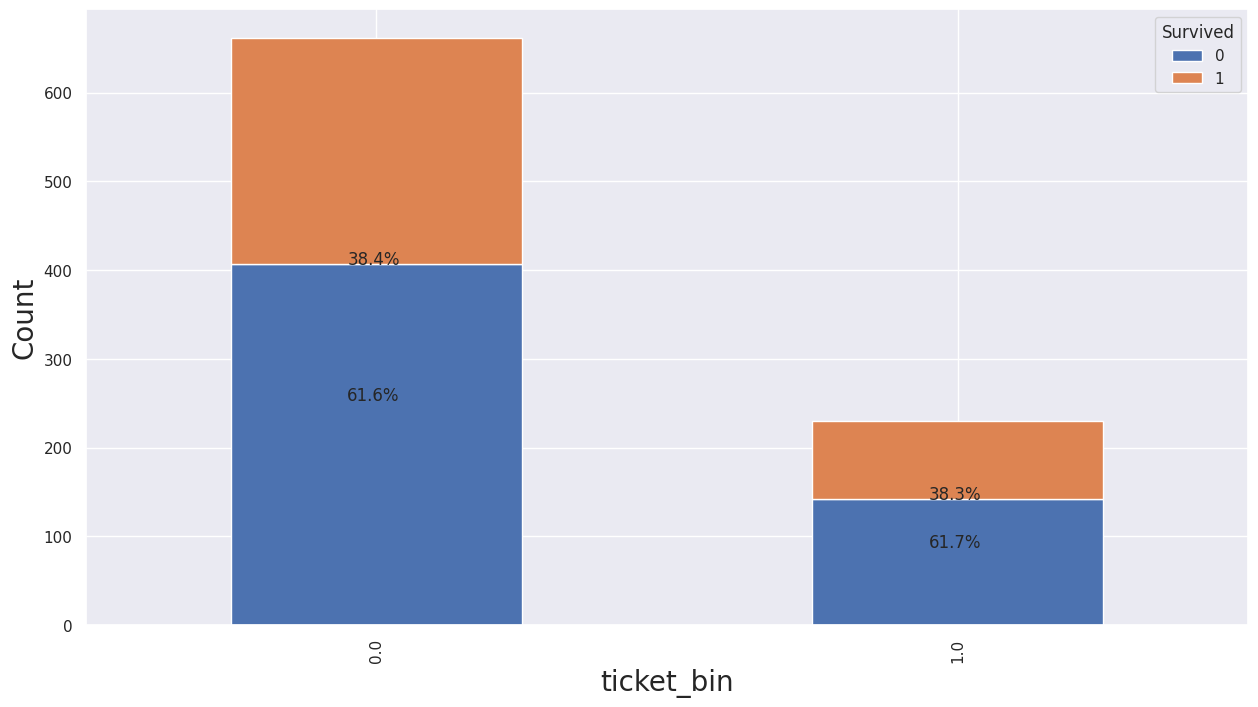

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'ticket_bin']).size().reset_index().pivot(columns='Survived', index='ticket_bin', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("ticket_bin", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.2)

Text(0.5, 1.0, 'Density plot')

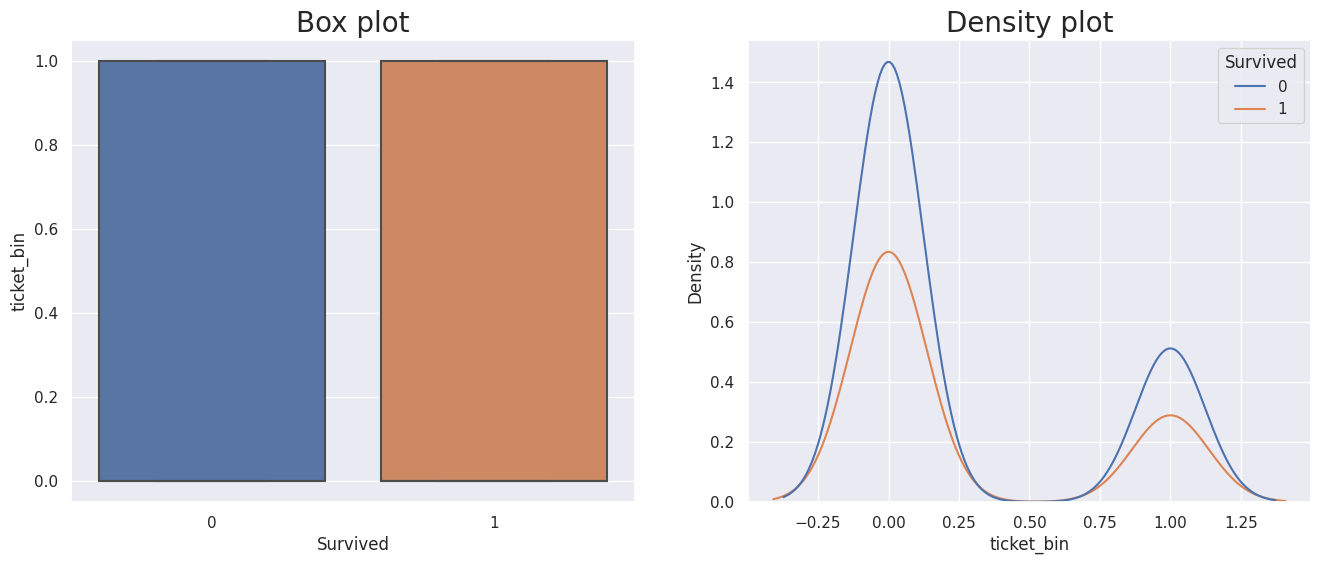

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="ticket_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'ticket_bin', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

## Cabin of the survivors

In [ ]:
data['Cabin'].value_counts()

nan            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

In [ ]:
def cabin_encoding(data):
    data['cabin_bin'] = [np.nan for i in range(len(data))]

    data_cabin_1 = data['Cabin'][data['Cabin'].str.startswith("A")]
    data_cabin_2 = data['Cabin'][data['Cabin'].str.startswith("B")]
    data_cabin_3 = data['Cabin'][data['Cabin'].str.startswith("C")]
    data_cabin_4 = data['Cabin'][data['Cabin'].str.startswith("D")]
    data_cabin_5 = data['Cabin'][data['Cabin'].str.startswith("E")]
    data_cabin_6 = data['Cabin'][~ (data['Cabin'].str.startswith("A") | data['Cabin'].str.startswith("B") | data['Cabin'].str.startswith("C")| data['Cabin'].str.startswith("D")| data['Cabin'].str.startswith("E"))]

    for i in range(len(data)):
        if data['Cabin'].iloc[i] in list(data_cabin_1):
            data['cabin_bin'].iloc[i] = 0
        elif data['Cabin'].iloc[i] in list(data_cabin_2):
            data['cabin_bin'].iloc[i] = 1
        elif data['Cabin'].iloc[i] in list(data_cabin_3):
            data['cabin_bin'].iloc[i] = 2
        elif data['Cabin'].iloc[i] in list(data_cabin_4):
            data['cabin_bin'].iloc[i] = 3
        elif data['Cabin'].iloc[i] in list(data_cabin_5):
            data['cabin_bin'].iloc[i] = 4
        elif data['Cabin'].iloc[i] in list(data_cabin_6):
            data['cabin_bin'].iloc[i] = 5
        elif data['Cabin'].iloc[i] == 'nan':
            data['cabin_bin'].iloc[i] = 6

    return data

In [ ]:
data = cabin_encoding(data)

Text(0.5, 1.0, 'Density plot')

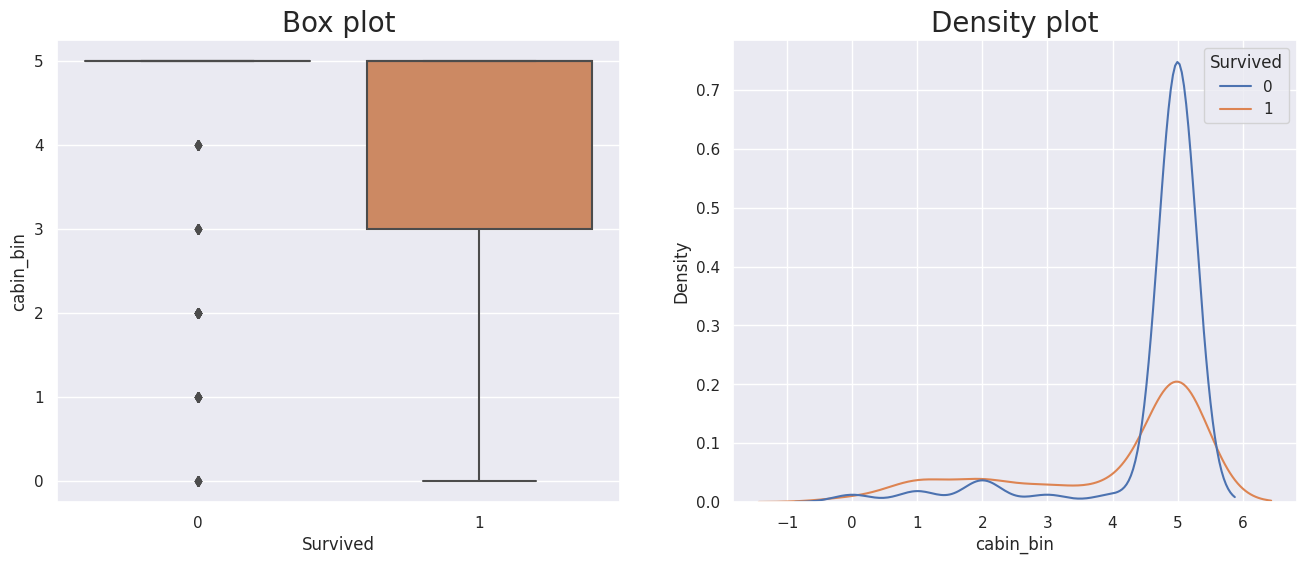

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="cabin_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'cabin_bin', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

Text(0.5, 1.0, 'Density plot')

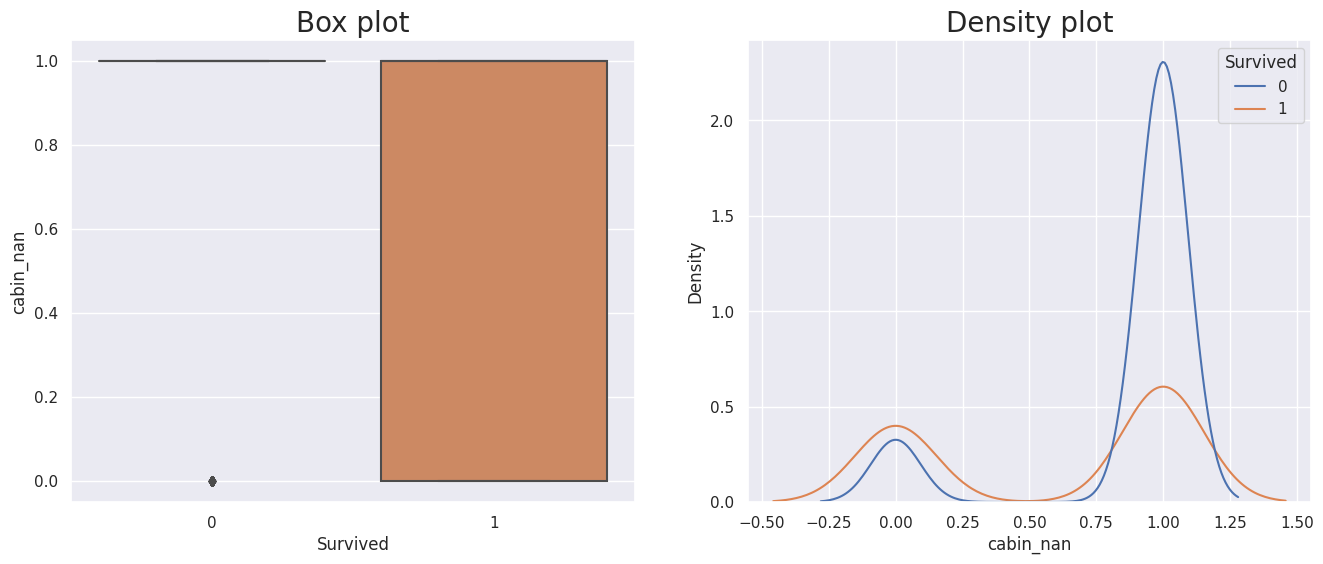

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="cabin_nan", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'cabin_nan', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

## Number of family members of the survivors ? (SibSp, Parch)

Text(0.5, 1.0, 'Density plot')

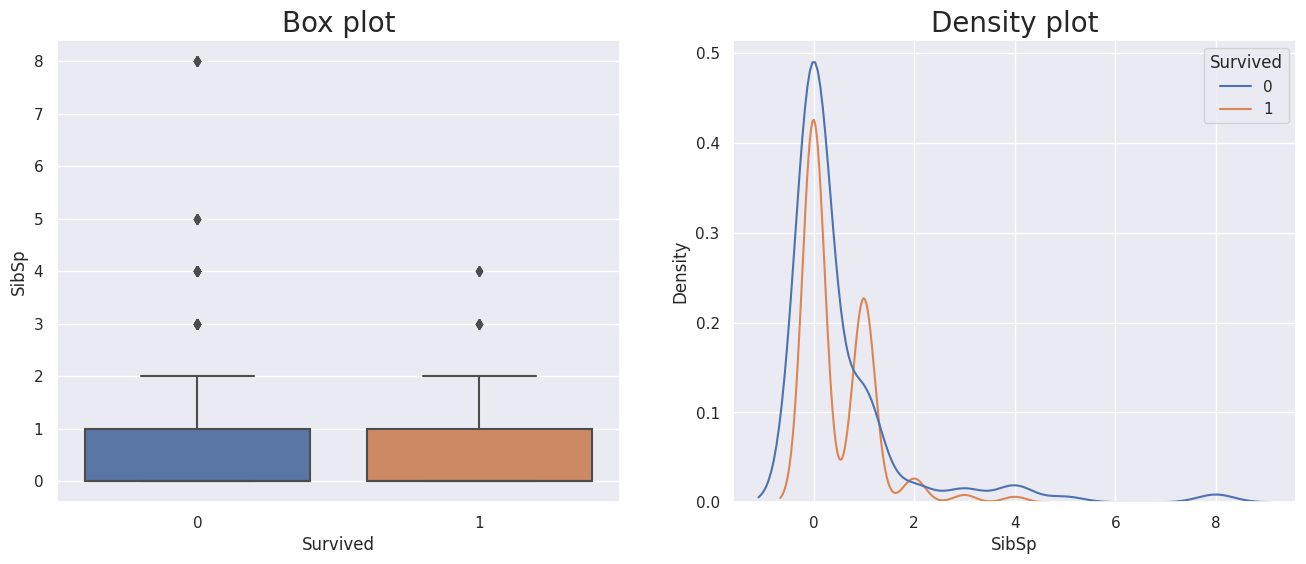

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="SibSp", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'SibSp', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

Text(0.5, 1.0, 'Density plot')

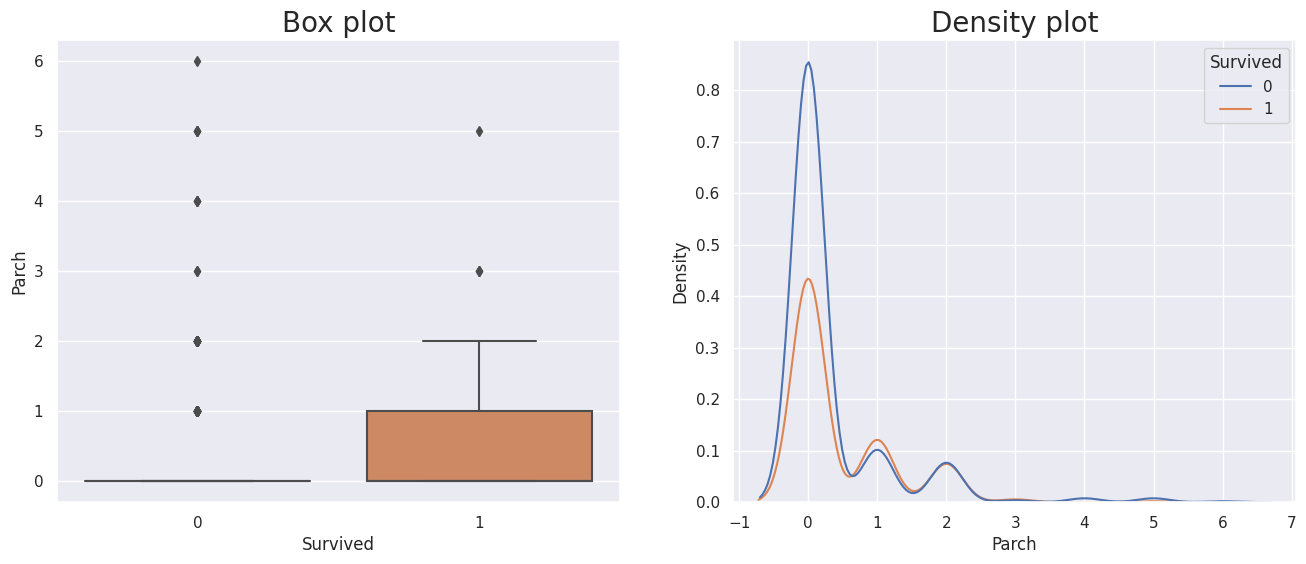

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Parch", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Parch', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

- Clearly, people who had more family aboard had a higher chance of survival

In [ ]:
data['family'] = data['SibSp'] + data['Parch']

Text(0.5, 1.0, 'Density plot')

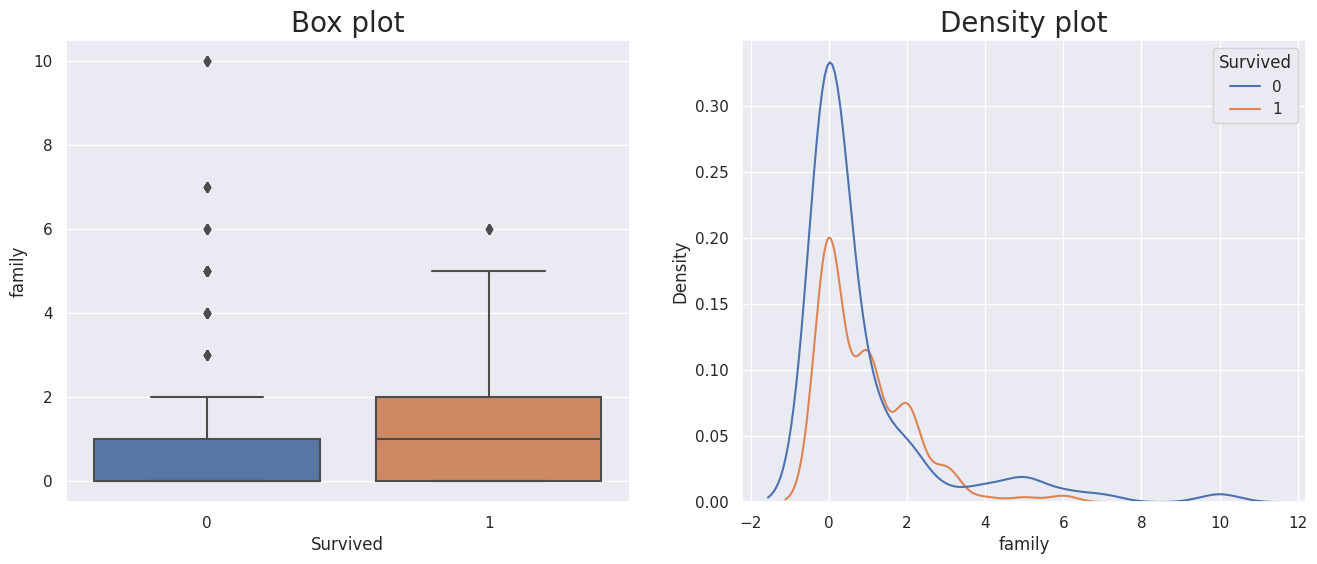

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="family", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'family', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

## Ticket class of the surivors ? (Pclass)

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


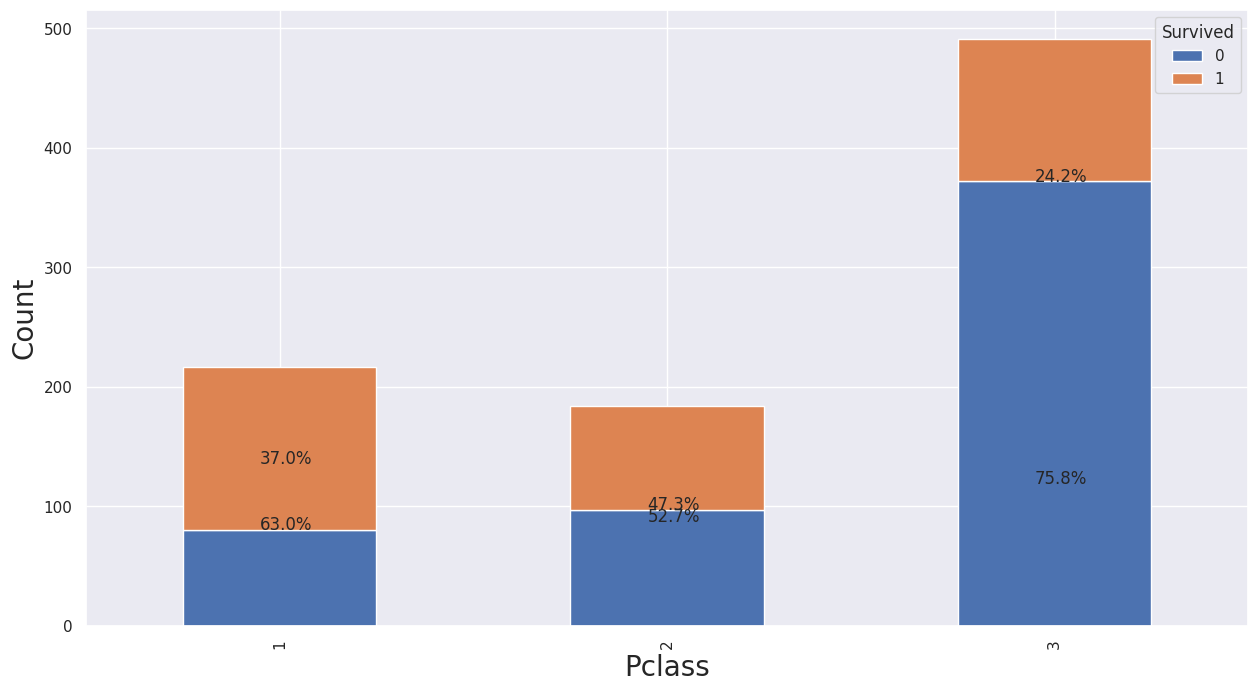

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Pclass", fontsize = 20)
df_p.set_ylabel("Count", fontsize = 20)

class_list = calculate_stacked_plot_percentages(df_plot, df_p)

plot_stacked_plot_percentages(class_list, df_p, 0.2)

- Around 500 passengers belonged to Class 3 which is the majority of the passengers and 75 % of them did not survive
- Class 1 and Class 2 had around half of the total Class 1 count but higher percentage of survivors
- Clearly, **percentage of Class 1 and Class 2 survivors is higher (63 % and 47 %) than the percentage of Class 3 survivors (24 %)**

Text(0.5, 1.0, 'Density plot')

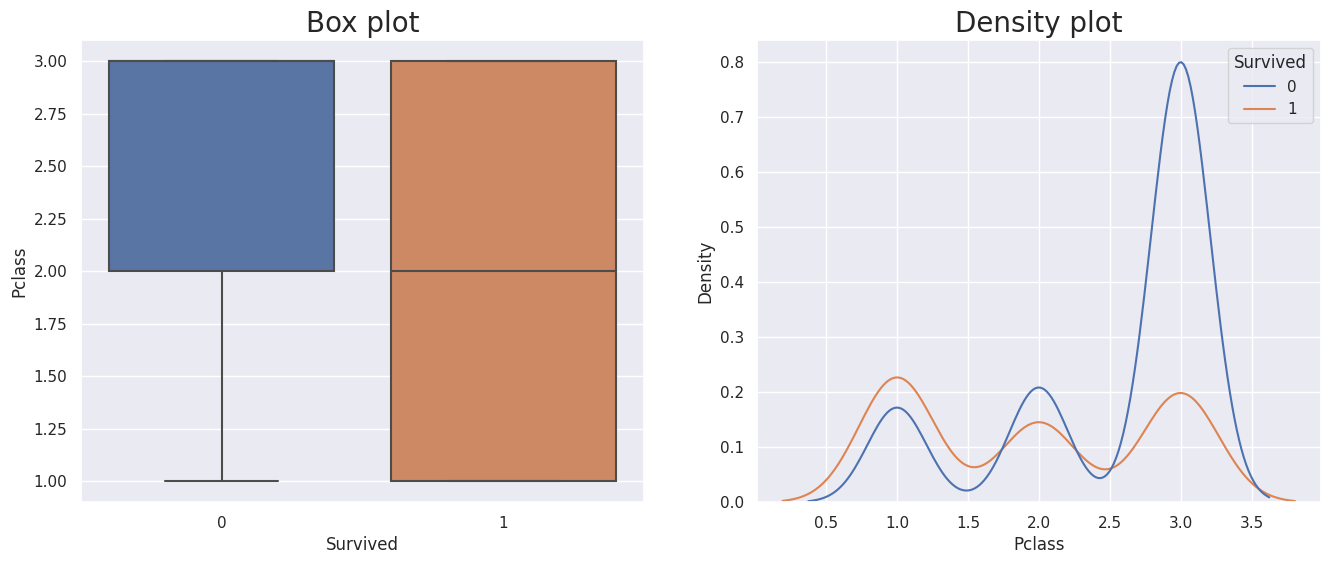

In [ ]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Pclass", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Pclass', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

# Data preprocessing

In [ ]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_nan', 'age_bin',
       'fare_bin', 'name_title', 'name_title_1', 'name_length',
       'name_length_bin', 'surname', 'ticket_bin', 'cabin_bin', 'family'],
      dtype='object')

In [ ]:
def combine_categorical_vars(data, col1,col2):
    #Get only the required columns from the dataframe
    cols = [col1, col2]
    one_hot_df = data.drop(columns = [col for col in data.columns if col not in cols])

    #Get the one hot encodings
    one_hot_df = pd.get_dummies(one_hot_df, columns = one_hot_df.columns)

    #Get the unique values mapped to integers
    arr = [int("".join(str(i) for i in List),2) for List in np.array(one_hot_df)] #Convert binary values to int
    map_dict = {}
    for index, j in enumerate(set(arr)): #Map each int value to index (0,1,..)
        map_dict[j] = index

    arr = list(map(lambda x: map_dict[x], arr))

    #Get the final labels
    data[col1+'_'+col2] = arr# np.argmax(np.array(one_hot_df), axis =1)
    return data

In [ ]:
data = combine_categorical_vars(data, 'Pclass','fare_bin')
data = combine_categorical_vars(data, 'Pclass_fare_bin', 'cabin_bin')
data = combine_categorical_vars(data, 'Sex','name_title')

data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,name_title_1,name_length,name_length_bin,surname,ticket_bin,cabin_bin,family,Pclass_fare_bin,Pclass_fare_bin_cabin_bin,Sex_name_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,...,0.0,23,0,2.0,1.0,5.0,1,3,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,...,0.0,51,1,3.0,1.0,2.0,1,2,3,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,...,0.0,22,0,4.0,1.0,5.0,0,3,1,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,...,0.0,44,1,5.0,0.0,2.0,1,2,3,4
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,...,0.0,24,0,5.0,0.0,5.0,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,...,1.0,21,0,1.0,0.0,5.0,0,4,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,...,0.0,28,0,5.0,0.0,1.0,0,2,8,5
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,...,0.0,40,1,5.0,1.0,5.0,3,3,1,5
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,...,0.0,21,0,2.0,0.0,2.0,0,2,3,1


In [ ]:
drop_list = ['Survived','PassengerId', 'Name', 'Ticket', 'Cabin', 'age_bin',  'SibSp', 'Parch','name_title','name_title_1', 'fare_bin', 'Pclass_fare_bin','name_length']
#drop_list = ['Survived','PassengerId', 'Name', 'Ticket', 'Cabin', 'age_bin',  'SibSp', 'Parch']

X = data.drop(columns =drop_list)
y = data['Survived']

print(X.columns)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'cabin_nan',
       'name_length_bin', 'surname', 'ticket_bin', 'cabin_bin', 'family',
       'Pclass_fare_bin_cabin_bin', 'Sex_name_title'],
      dtype='object')


In [ ]:
cols_dummies = ['ticket_bin', 'surname', 'name_length_bin', 'Embarked','cabin_nan','Pclass']
#cols_dummies = ['ticket_bin', 'surname','Pclass', 'Embarked', 'Pclass_fare_bin_cabin_bin', 'Sex_name_title']
X = pd.get_dummies(X, columns = cols_dummies)

In [ ]:
categorical_features = ['Sex', 'pClass', 'Embarked' ]
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'family','name_length']
for col in categorical_features:
    if col in X.columns:
        try:
            le = LabelEncoder()
            X[col]= le.fit_transform(X[col])
        except:
            pass

for col in numerical_features:
    le = MinMaxScaler()
    if col in X.columns:
        X[col]= le.fit_transform(np.array(X[col]).reshape(-1,1))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 100)

# Training the model
extra_tree_forest.fit(X,y)

# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [ ]:
ind = np.argsort(feature_importance_normalized)[::-1]   #indices sorted in descending order
X_val = [X.columns[ind[i]] for i in range(0,7)]
y_val = [feature_importance_normalized[ind[i]] for i in range(0,7)]

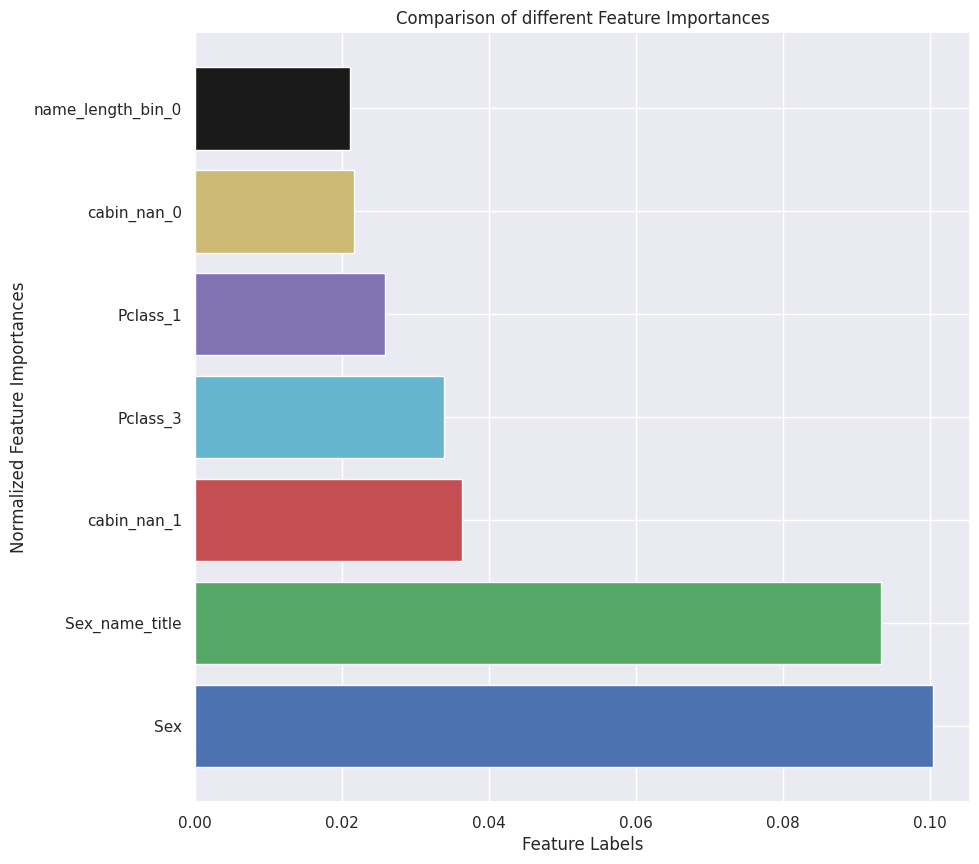

In [ ]:
plt.figure(figsize = (10,10))
plt.barh(X_val, y_val, color = ['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.xlabel('Feature Labels')
plt.ylabel('Normalized Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

In [ ]:
#X = X.drop(columns = [cols for cols in X.columns if cols not in X_val])

In [ ]:
X.columns

Index(['Sex', 'Age', 'Fare', 'cabin_bin', 'family',
       'Pclass_fare_bin_cabin_bin', 'Sex_name_title', 'ticket_bin_0.0',
       'ticket_bin_1.0', 'surname_0.0', 'surname_1.0', 'surname_2.0',
       'surname_3.0', 'surname_4.0', 'surname_5.0', 'name_length_bin_0',
       'name_length_bin_1', 'name_length_bin_2', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'cabin_nan_0', 'cabin_nan_1', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

In [ ]:
#Train test stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

<Axes: >

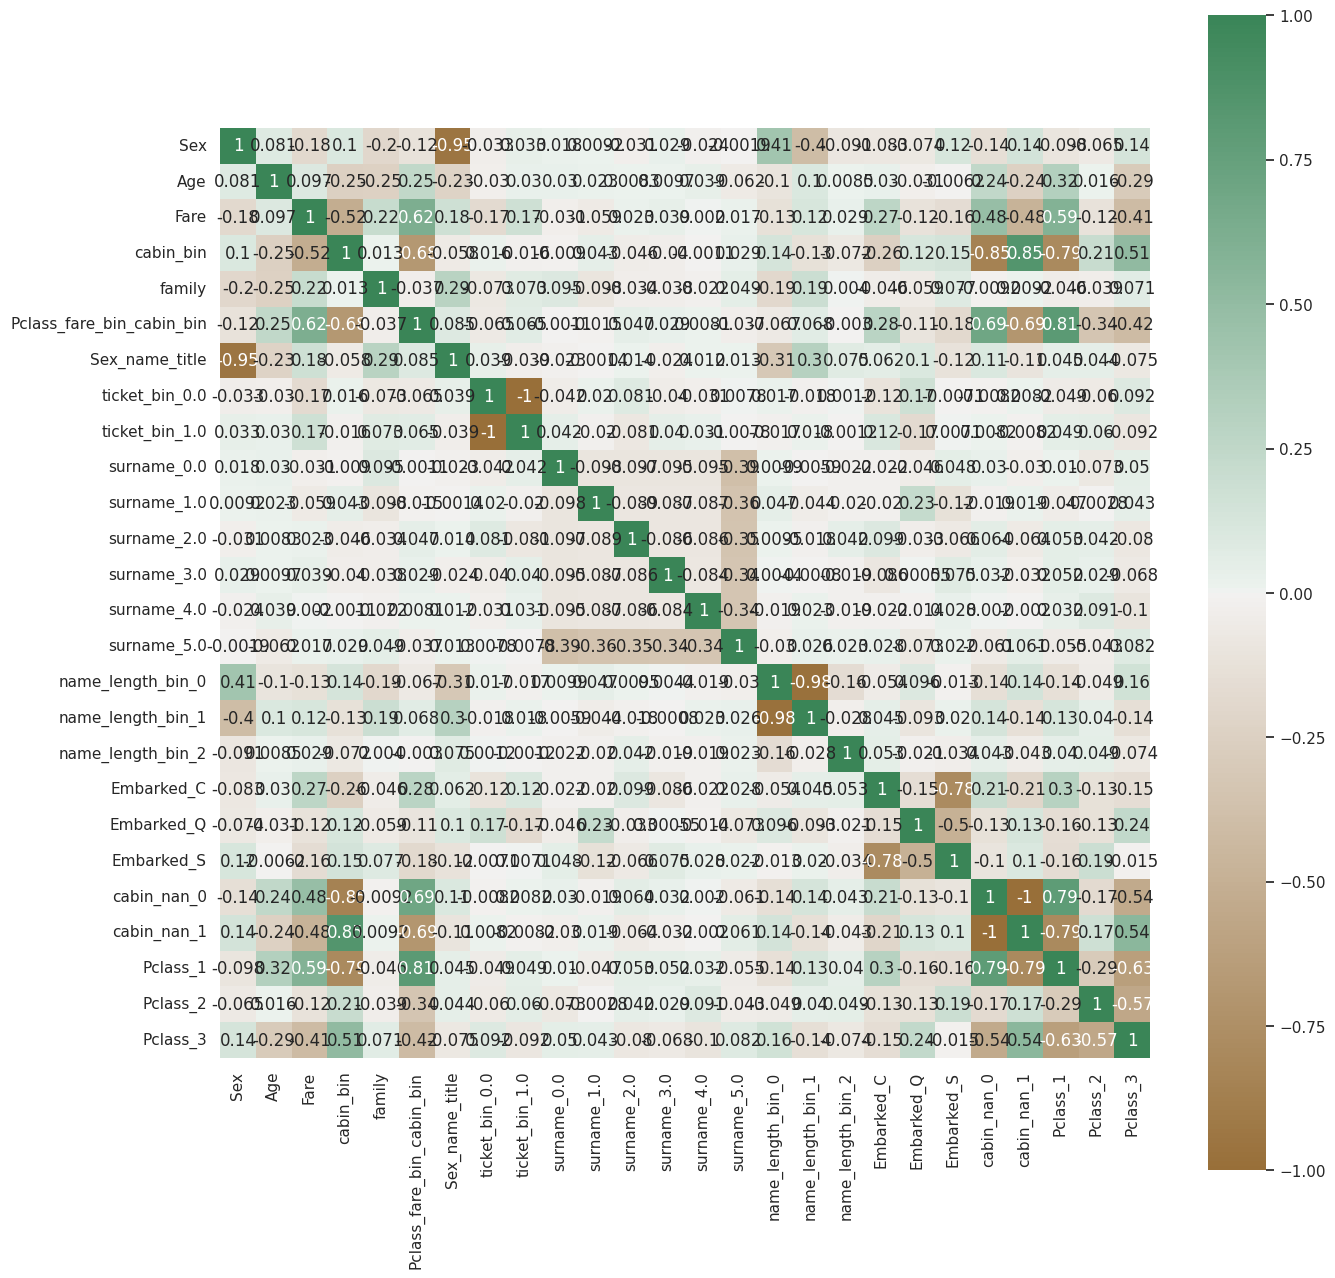

In [ ]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(X.corr(),
            #vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True,
            annot=True)

- name_title and Sex
- combining fare, cabin_bin and Pclass

In [ ]:
X_train[:5]

,Sex,Age,Fare,cabin_bin,family,Pclass_fare_bin_cabin_bin,Sex_name_title,ticket_bin_0.0,ticket_bin_1.0,surname_0.0,...,name_length_bin_1,name_length_bin_2,Embarked_C,Embarked_Q,Embarked_S,cabin_nan_0,cabin_nan_1,Pclass_1,Pclass_2,Pclass_3
126,1,0.3500,0.015127,5.0,0.0,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
652,1,0.2625,0.016461,5.0,0.0,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,1
111,0,0.1750,0.028213,5.0,0.1,1,5,1,0,0,...,0,0,1,0,0,0,1,0,0,1
786,0,0.2250,0.014631,5.0,0.0,1,5,1,0,1,...,0,0,0,0,1,0,1,0,0,1
364,1,0.3500,0.030254,5.0,0.1,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
'''def categorical_encoding(X_train, X_test, col):
    if col in X_train.columns:
        le = LabelEncoder()
        X_train[col]= le.fit_transform(X_train[col])
        X_test[col]= le.transform(X_test[col])

    return X_train, X_test


def normalize(X_train, X_test, col):
    if col in X_train.columns:
        le = MinMaxScaler()
        X_train[col]= le.fit_transform(np.array(X_train[col]).reshape(-1,1))
        X_test[col]= le.transform(np.array(X_test[col]).reshape(-1,1))

    return X_train, X_test'''

'def categorical_encoding(X_train, X_test, col):\n    if col in X_train.columns:\n        le = LabelEncoder()\n        X_train[col]= le.fit_transform(X_train[col])\n        X_test[col]= le.transform(X_test[col])\n    \n    return X_train, X_test\n\n\ndef normalize(X_train, X_test, col):\n    if col in X_train.columns:\n        le = MinMaxScaler()\n        X_train[col]= le.fit_transform(np.array(X_train[col]).reshape(-1,1))\n        X_test[col]= le.transform(np.array(X_test[col]).reshape(-1,1))\n    \n    return X_train, X_test'

In [ ]:
'''categorical_features = ['Sex', 'pClass', 'Embarked' ]
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'family']

for col in categorical_features:
    X_train, Xtest = categorical_encoding(X_train, X_test, col)

for col in numerical_features:
    X_train, Xtest = normalize(X_train, X_test, col)
print(X_train[:5], X_test[:5])'''

"categorical_features = ['Sex', 'pClass', 'Embarked' ]\nnumerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'family']\n\nfor col in categorical_features:\n    X_train, Xtest = categorical_encoding(X_train, X_test, col)\n\nfor col in numerical_features:\n    X_train, Xtest = normalize(X_train, X_test, col)\nprint(X_train[:5], X_test[:5])"

## Correlation w target variable

In [ ]:
X = data
categorical_features_ = ['Sex', 'pClass', 'Embarked' ]
numerical_features_ = ['Age', 'SibSp', 'Parch', 'Fare']

for col in categorical_features_:
    if col in X.columns:
        le = LabelEncoder()
        X[col]= le.fit_transform(X[col])

for col in numerical_features_:
    if col in X.columns:
        le = MinMaxScaler()
        X[col]= le.fit_transform(np.array(X[col]).reshape(-1,1))

<Axes: >

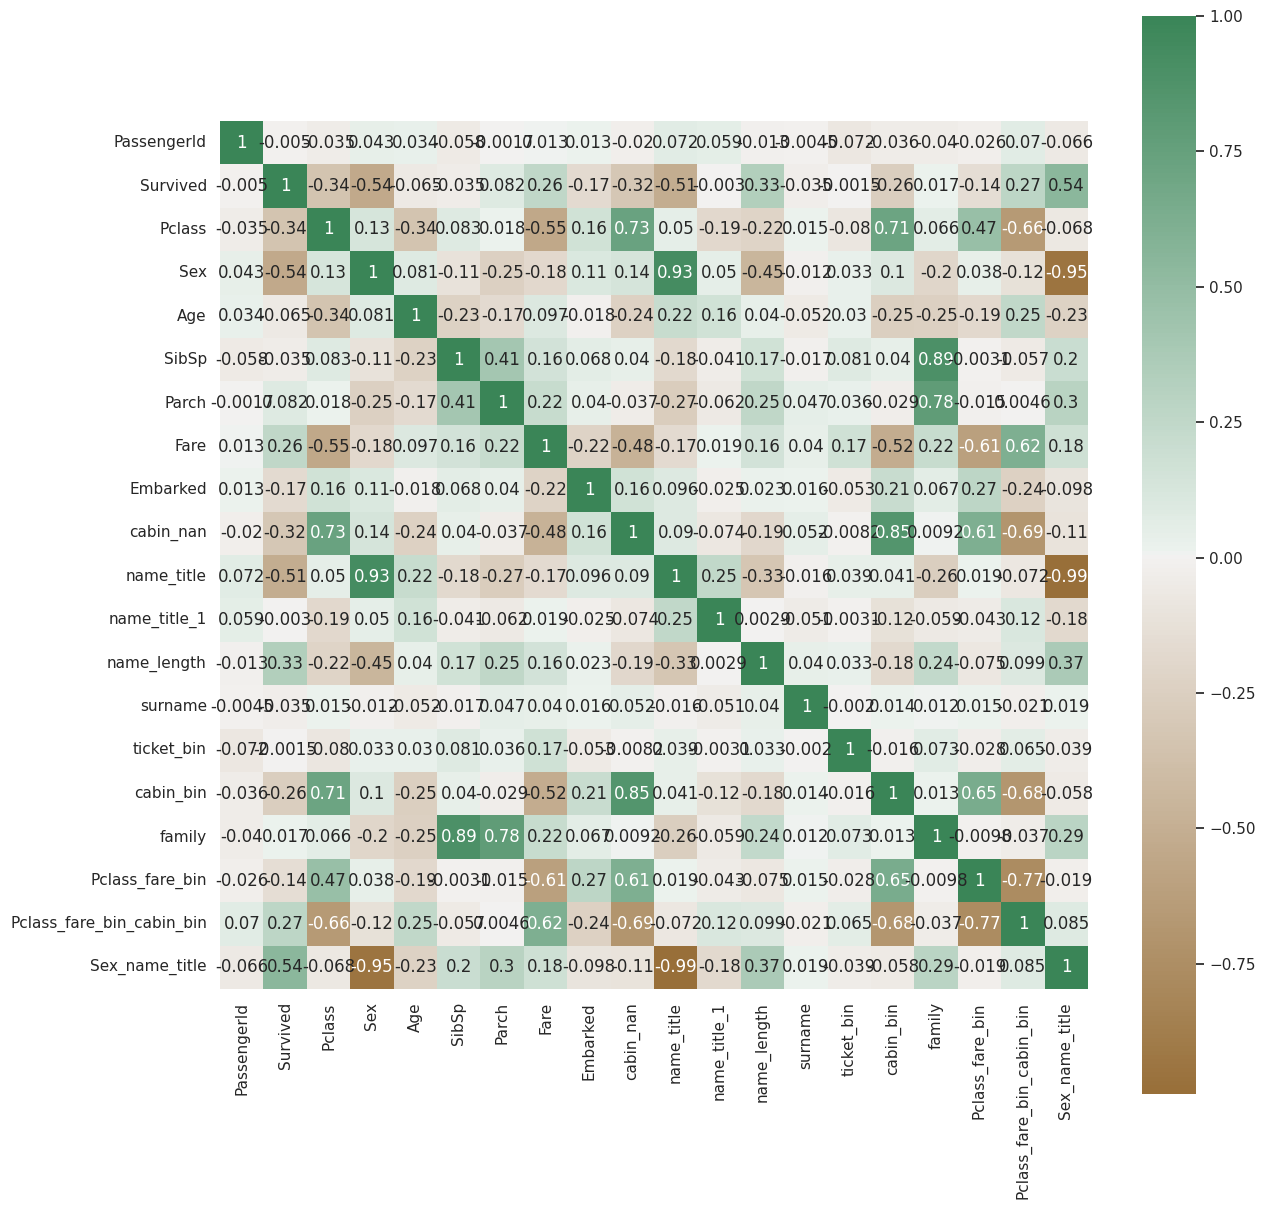

In [ ]:
sns.set(rc = {'figure.figsize':(14,14)})
sns.heatmap(X.corr(),
            #vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True,
            annot=True)

- name_title is highly negatively correlated with the output class
- Fare and Pclass are also highly negatively correlated
- Pclass and the output class are moderately negatively correlated

### Visualizing

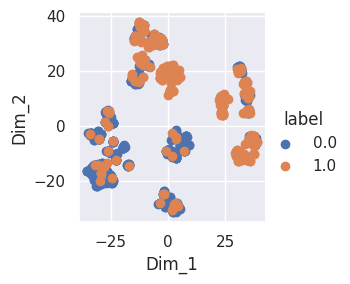

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data_1000 = X_train
labels_1000 = y_train

model = TSNE(n_components = 2, random_state = 0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000

tsne_data = model.fit_transform(data_1000)

# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,columns =("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue ="label").map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

# Baseline Model

For baseline model to compare further models with, i used a RandomForest model since it is a simple, robust and high performing classification algorithm

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
skf = KFold(n_splits=15, shuffle=True)

for train_idx, test_idx in skf.split(X_train, y_train):
    #print(train_idx, test_idx)
    #print(data.iloc[train_idx], y.iloc[train_idx])
    rf = RandomForestClassifier(n_estimators = 500)
    rf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    print('Accuracy for th fold CV is', accuracy_score(rf.predict(X_train.iloc[test_idx]), y_train.iloc[test_idx]))

Accuracy for th fold CV is 0.8333333333333334
Accuracy for th fold CV is 0.9259259259259259
Accuracy for th fold CV is 0.7962962962962963
Accuracy for th fold CV is 0.8333333333333334
Accuracy for th fold CV is 0.7592592592592593
Accuracy for th fold CV is 0.7962962962962963
Accuracy for th fold CV is 0.7358490566037735
Accuracy for th fold CV is 0.8113207547169812
Accuracy for th fold CV is 0.8679245283018868
Accuracy for th fold CV is 0.7358490566037735
Accuracy for th fold CV is 0.7735849056603774
Accuracy for th fold CV is 0.8301886792452831
Accuracy for th fold CV is 0.7924528301886793
Accuracy for th fold CV is 0.8113207547169812
Accuracy for th fold CV is 0.8679245283018868


In [ ]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(rf.predict(X_test), y_test))

Final accuracy score : 0.8666666666666667


## Hyperparameter optimization using hyperopt

In [ ]:
#Reference : https://www.kaggle.com/sivasaiyadav8143/10-hyperparameter-optimization-frameworks#3.-Hyperopt ; https://www.kaggle.com/maxdiazbattan/titanic-top-3-eda-f-eng-avg-6-models-optuna
criterion_list = ["gini", "entropy"]

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,1000)),
    'criterion': hp.choice('criterion', criterion_list)
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print(best)

new best:
0.8289829192546584
{'criterion': 'gini', 'max_depth': 13, 'max_features': 4, 'n_estimators': 799}
new best:
0.8352484472049688
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'n_estimators': 182}
100%|██████████| 10/10 [00:27<00:00,  2.77s/trial, best loss: -0.8352484472049688]
{'criterion': 1, 'max_depth': 5, 'max_features': 3, 'n_estimators': 181}


In [ ]:
best

{'criterion': 1, 'max_depth': 5, 'max_features': 3, 'n_estimators': 181}

In [ ]:
#rf = RandomForestClassifier(criterion = 'gini', max_depth= 10, n_estimators= 500)
rf = RandomForestClassifier(criterion = criterion_list[best['criterion']], max_depth= best['max_depth'], n_estimators= best['n_estimators'])
rf.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(rf.predict(X_test), y_test))

Final accuracy score : 0.8333333333333334


# Model 1: Logistic Regression, GLM

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
'''penalty_list = ['l1', 'l2', 'elasticnet', 'none']

def hyperopt_train_test(params):
    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'penalty': hp.choice('penalty', penalty_list),
    'C': hp.choice('C', range(0,100))
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc ,'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)
print(best)'''

"penalty_list = ['l1', 'l2', 'elasticnet', 'none']\n\ndef hyperopt_train_test(params):\n    clf = LogisticRegression(**params)\n    return cross_val_score(clf, X_train, y_train).mean()\n\nspace = {\n    'penalty': hp.choice('penalty', penalty_list),\n    'C': hp.choice('C', range(0,100))\n            }\nbest = 0\ndef f(params):\n    global best\n    acc = hyperopt_train_test(params)\n    if acc > best:\n      best = acc\n      print( 'new best:', best, params)\n    return {'loss': -acc ,'status': STATUS_OK}\ntrials = Trials()\nbest = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)\nprint(best)"

In [ ]:
'''best'''

'best'

In [ ]:
'''lr = LogisticRegression(C = best['C'], penalty = penalty_list[best['penalty']])
lr.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(lr.predict(X_test), y_test))'''

"lr = LogisticRegression(C = best['C'], penalty = penalty_list[best['penalty']])\nlr.fit(X_train, y_train)\nprint('Final accuracy score :',  accuracy_score(lr.predict(X_test), y_test))"

# Model 2 : Generative Additive Models

In [ ]:
!pip install pygam
from pygam import LogisticGAM
import pygam

In [ ]:
gam = LogisticGAM().fit(X_train, y_train)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      43.893
Link Function:                        LogitLink Log Likelihood:                                  -303.0503
Number of Samples:                          801 AIC:                                              693.8865
                                                AICc:                                             699.3434
                                                UBRE:                                               2.9101
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4316
Feature Function                  Lam

In [ ]:
gam.accuracy(X_test, y_test)

0.8666666666666667

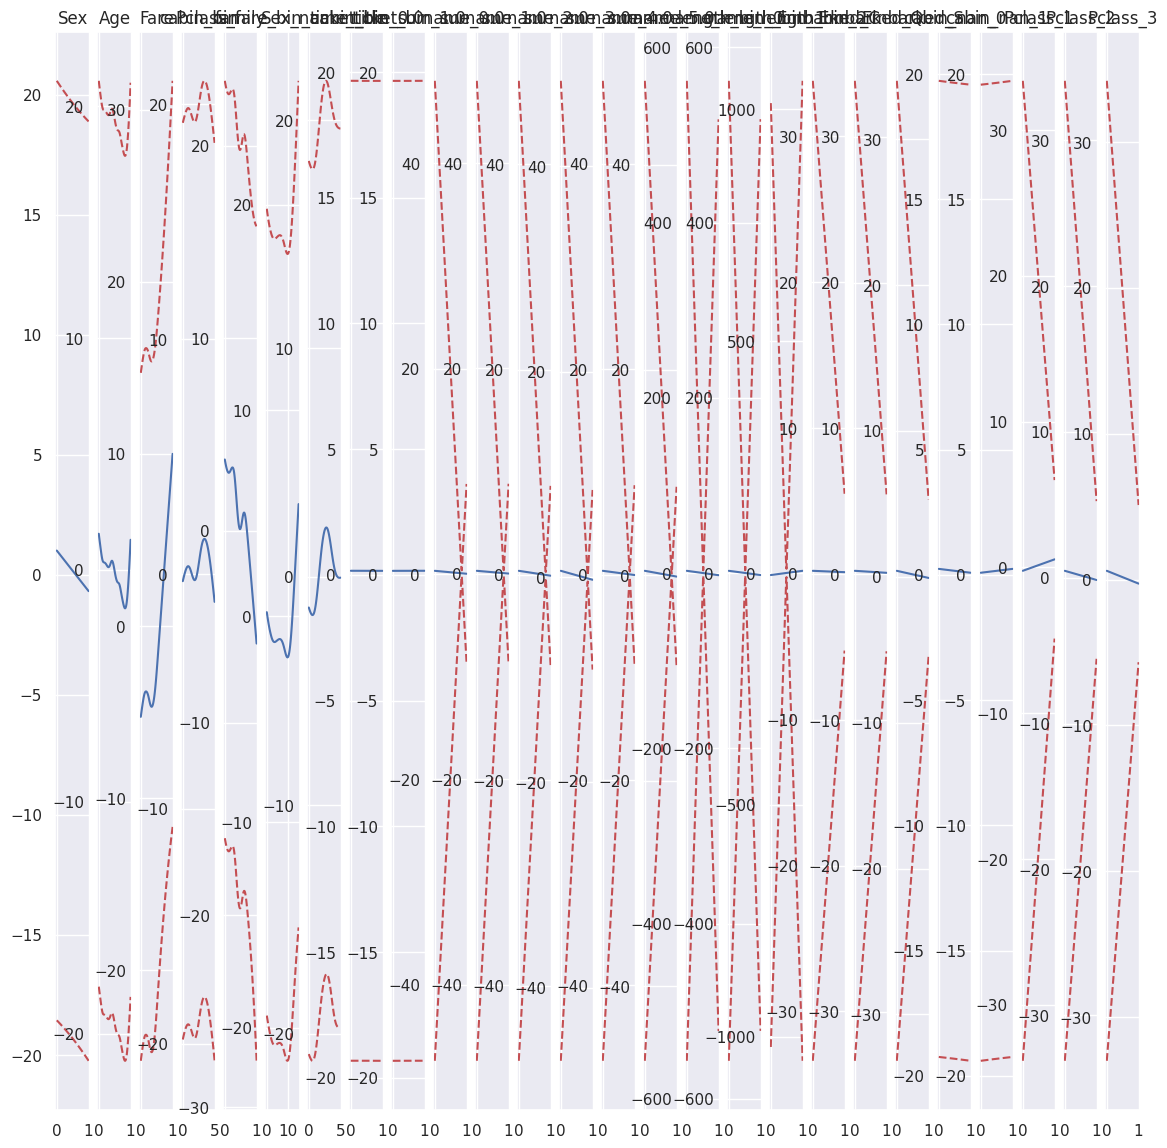

In [ ]:
fig, axs = plt.subplots(1, len(X_train.columns))
titles = X_train.columns

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

# Model 3: Ensembles

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
criterion_list = ["gini", "entropy"]

def hyperopt_train_test(params):
    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

space = {
    'learning_rate' : hp.choice('learning_rate', [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.6,1]),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,5)),
    'n_estimators': hp.choice('n_estimators', range(1,1000)),
    'subsample' : hp.choice('subsample', [0,0.5,1])
            }
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
      best = acc
      print( 'new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print(best)

[21:51:11] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

new best:
0.6167313664596273
{'learning_rate': 0.05, 'max_depth': 11, 'max_features': 3, 'n_estimators': 814, 'subsample': 0}
[21:51:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:13] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[21:51:20] WARNING: ../src/learner.cc:767: 
Parameters: { "max_f

In [ ]:
best

{'learning_rate': 2,
 'max_depth': 5,
 'max_features': 1,
 'n_estimators': 266,
 'subsample': 1}

In [ ]:
if best['subsample'] >=1:
    best['subsample'] = 1
xgb = XGBClassifier(subsample = best['subsample'], learning_rate = best['learning_rate'], max_depth= best['max_depth'], n_estimators= best['n_estimators'], objective= 'binary:logistic')
xgb.fit(X_train, y_train)
print('Final accuracy score :',  accuracy_score(xgb.predict(X_test), y_test))

Final accuracy score : 0.6222222222222222


# Voting Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, VotingClassifier, VotingRegressor

In [ ]:
'''vc = VotingClassifier([("xgb_m",xgb),
                       ("log",lr),
                       ("rf_m",rf)],
                      voting = "hard")

vc.fit(X_train,y_train)'''

'vc = VotingClassifier([("xgb_m",xgb),\n                       ("log",lr),\n                       ("rf_m",rf)],\n                      voting = "hard")\n\nvc.fit(X_train,y_train)'

In [ ]:
'''print('Final accuracy score :',  accuracy_score(vc.predict(X_test), y_test))'''

"print('Final accuracy score :',  accuracy_score(vc.predict(X_test), y_test))"

# Test predictions

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/titanic/test.csv')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
print(test.columns)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [ ]:
#categorical_features = ['Sex', 'pClass', 'Embarked' ]
#numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'family', 'name_length']

def clean_data(test):
    for col in [test.columns[i] for i in [1,3,4,5,6,7,8,10]]:
        if any(test[col].isna()) == True and col in ['Age', 'Fare']:
            test = impute_missing_data(test, col, median =True, mode=False)


    return test


def preprocess(test):
    test['Cabin'] = test['Cabin'].fillna('nan')
    test['cabin_nan'] = [1 if test['Cabin'].iloc[i] =='nan' else 0 for i in range(len(test))]

    test = ticket_bin_encoding(test)
    test = name_encoding(test)
    test = cabin_encoding(test)
    test['family'] = test['SibSp'] + test['Parch']
    test['name_length'] = test['Name'].map(lambda x: len(str(x)))
    #test = name_vectorizer(test)
    test = name_encoding_1(test)
    test = surname_encoding(test)
    test = fares_categorical(test)
    map_obj = {(-1.0, 171.0) : 0, (171.0, 342.0): 1,(342.0, 512.0):2}
    test['fare_bin'] = test['fare_bin'].map(lambda x: map_obj[(x.left, x.right)])
    test = combine_categorical_vars(test, 'Pclass','fare_bin')
    test = combine_categorical_vars(test, 'Pclass_fare_bin', 'cabin_bin')
    test = combine_categorical_vars(test, 'Sex','name_title')
    test = name_length_categorical(test)
    map_obj = {(test['name_length_bin'].value_counts().keys()[0].left, test['name_length_bin'].value_counts().keys()[0].right) : 0, (test['name_length_bin'].value_counts().keys()[1].left, test['name_length_bin'].value_counts().keys()[1].right): 1,(test['name_length_bin'].value_counts().keys()[2].left, test['name_length_bin'].value_counts().keys()[2].right):2}
    test['name_length_bin'] = test['name_length_bin'].map(lambda x: map_obj[(x.left, x.right)])

    drop_list = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'ticket_bin', 'cabin_nan', 'Fare']
    drop_list = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch','name_title','name_title_1', 'fare_bin', 'Pclass_fare_bin','name_length']

    test = pd.get_dummies(test, columns = cols_dummies)

    test = test.drop(columns = drop_list)##Incl cabin

    for col in categorical_features:
        if col in test.columns:
            try:
                le = LabelEncoder()
                test[col]= le.fit_transform(test[col])
            except:
                pass

    for col in numerical_features:
        le = MinMaxScaler()
        if col in test.columns:
            test[col]= le.fit_transform(np.array(test[col]).reshape(-1,1))


    return test

In [ ]:
test = clean_data(test)

for col in [test.columns[i] for i in [1,3,4,5,6,7,8,10]]:
    print(col,':', any(test[col].isna()))

test = preprocess(test)

Pclass : False
Sex : False
Age : False
SibSp : False
Parch : False
Ticket : False
Fare : False
Embarked : False


In [ ]:
test

,Sex,Age,Fare,cabin_bin,family,Pclass_fare_bin_cabin_bin,Sex_name_title,ticket_bin_0.0,ticket_bin_1.0,surname_0.0,...,name_length_bin_1,name_length_bin_2,Embarked_C,Embarked_Q,Embarked_S,cabin_nan_0,cabin_nan_1,Pclass_1,Pclass_2,Pclass_3
0,1,0.452723,0.015282,5.0,0.0,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,0.617566,0.013663,5.0,0.1,1,4,1,0,0,...,1,0,0,0,1,0,1,0,0,1
2,1,0.815377,0.018909,5.0,0.0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,1,0
3,1,0.353818,0.016908,5.0,0.0,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,1
4,0,0.287881,0.023984,5.0,0.2,1,4,1,0,0,...,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0.353818,0.015713,5.0,0.0,1,1,0,1,1,...,0,0,0,0,1,0,1,0,0,1
414,0,0.512066,0.212559,2.0,0.0,8,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
415,1,0.505473,0.014151,5.0,0.0,1,1,0,1,1,...,0,0,0,0,1,0,1,0,0,1
416,1,0.353818,0.015713,5.0,0.0,1,1,1,0,0,...,0,0,0,0,1,0,1,0,0,1


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Dataset/titanic/gender_submission.csv')
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
pred = gam.predict(test)
gam_pred = [1 if i == True else 0 for i in pred ]

'''rf_pred = rf.predict(test)

lr_pred = lr.predict(test)

xgb_pred =xgb.predict(test)

vc_pred = vc.predict(test)'''

'rf_pred = rf.predict(test)\n\nlr_pred = lr.predict(test)\n\nxgb_pred =xgb.predict(test)\n\nvc_pred = vc.predict(test)'

In [ ]:
'''final_pred = [1 if (i + 2*j+k)/4 >=0.5 else 0 for i,j,k in zip(gam_pred, rf_pred, lr_pred)]'''

'final_pred = [1 if (i + 2*j+k)/4 >=0.5 else 0 for i,j,k in zip(gam_pred, rf_pred, lr_pred)]'

In [ ]:
X_test.columns

Index(['Sex', 'Age', 'Fare', 'cabin_bin', 'family',
       'Pclass_fare_bin_cabin_bin', 'Sex_name_title', 'ticket_bin_0.0',
       'ticket_bin_1.0', 'surname_0.0', 'surname_1.0', 'surname_2.0',
       'surname_3.0', 'surname_4.0', 'surname_5.0', 'name_length_bin_0',
       'name_length_bin_1', 'name_length_bin_2', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'cabin_nan_0', 'cabin_nan_1', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

In [ ]:
test.columns

Index(['Sex', 'Age', 'Fare', 'cabin_bin', 'family',
       'Pclass_fare_bin_cabin_bin', 'Sex_name_title', 'ticket_bin_0.0',
       'ticket_bin_1.0', 'surname_0.0', 'surname_1.0', 'surname_2.0',
       'surname_3.0', 'surname_4.0', 'surname_5.0', 'name_length_bin_0',
       'name_length_bin_1', 'name_length_bin_2', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'cabin_nan_0', 'cabin_nan_1', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

In [ ]:
submission['Survived'] = rf.predict(test)#final_pred#vc_pred#final_pred #gam_pred #rf.predict(test)

In [ ]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
submission.to_csv('./submission.csv', index = False)

## Correlation between features and target variable

<Axes: >

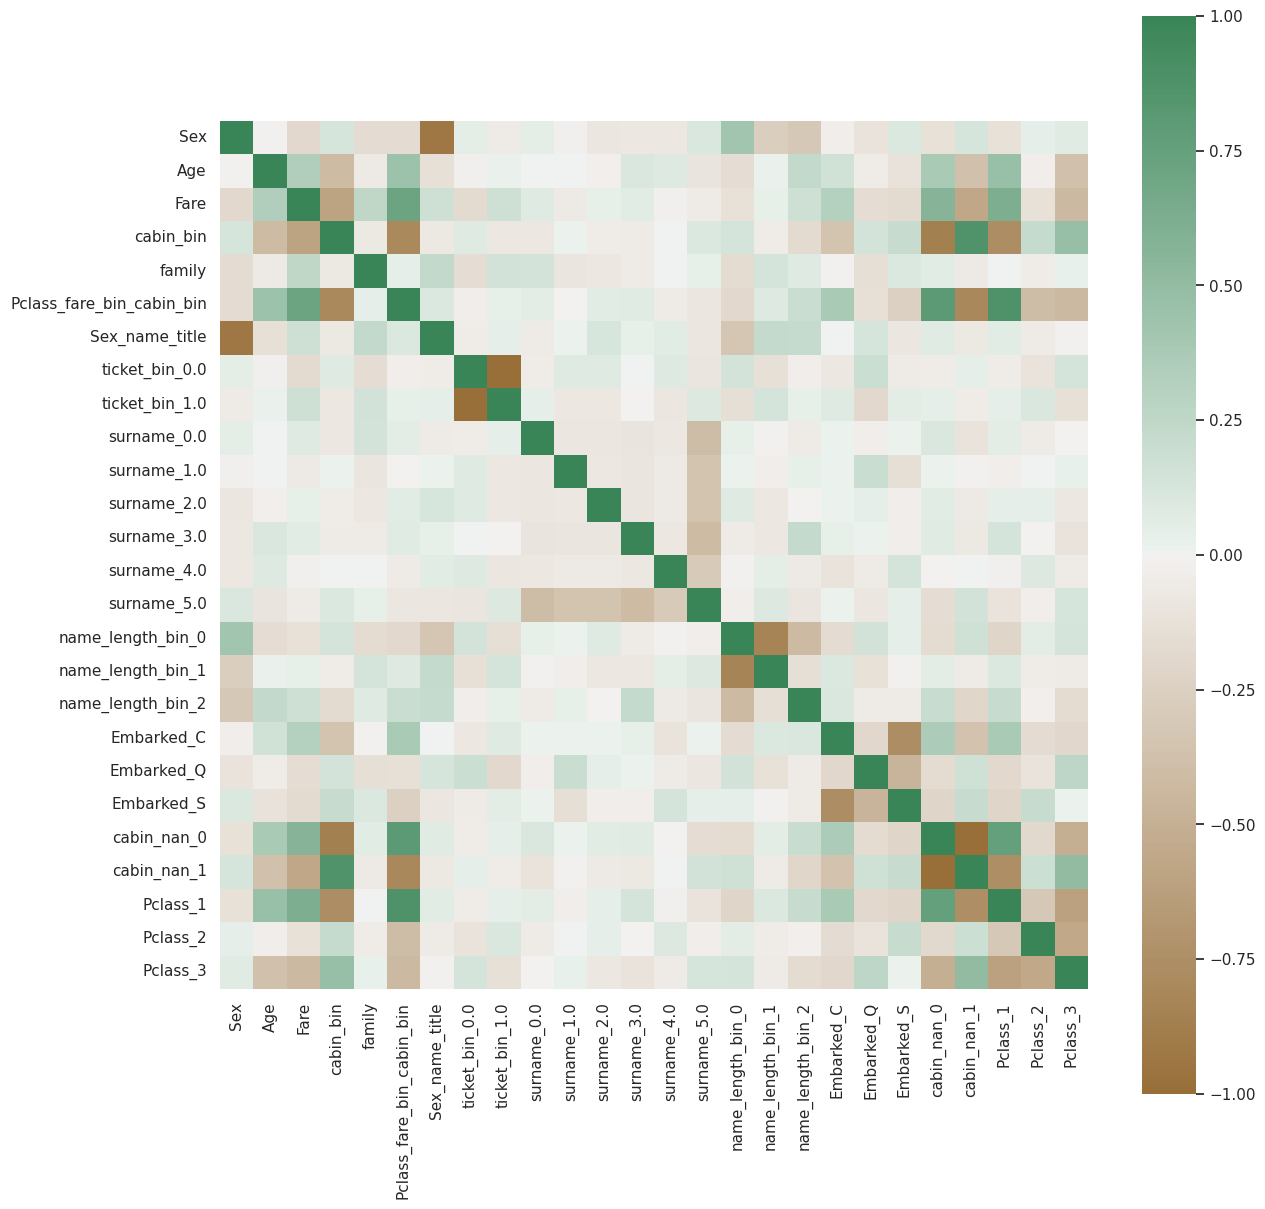

In [ ]:
sns.heatmap(test.corr(),
            #vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)

<BarContainer object of 26 artists>

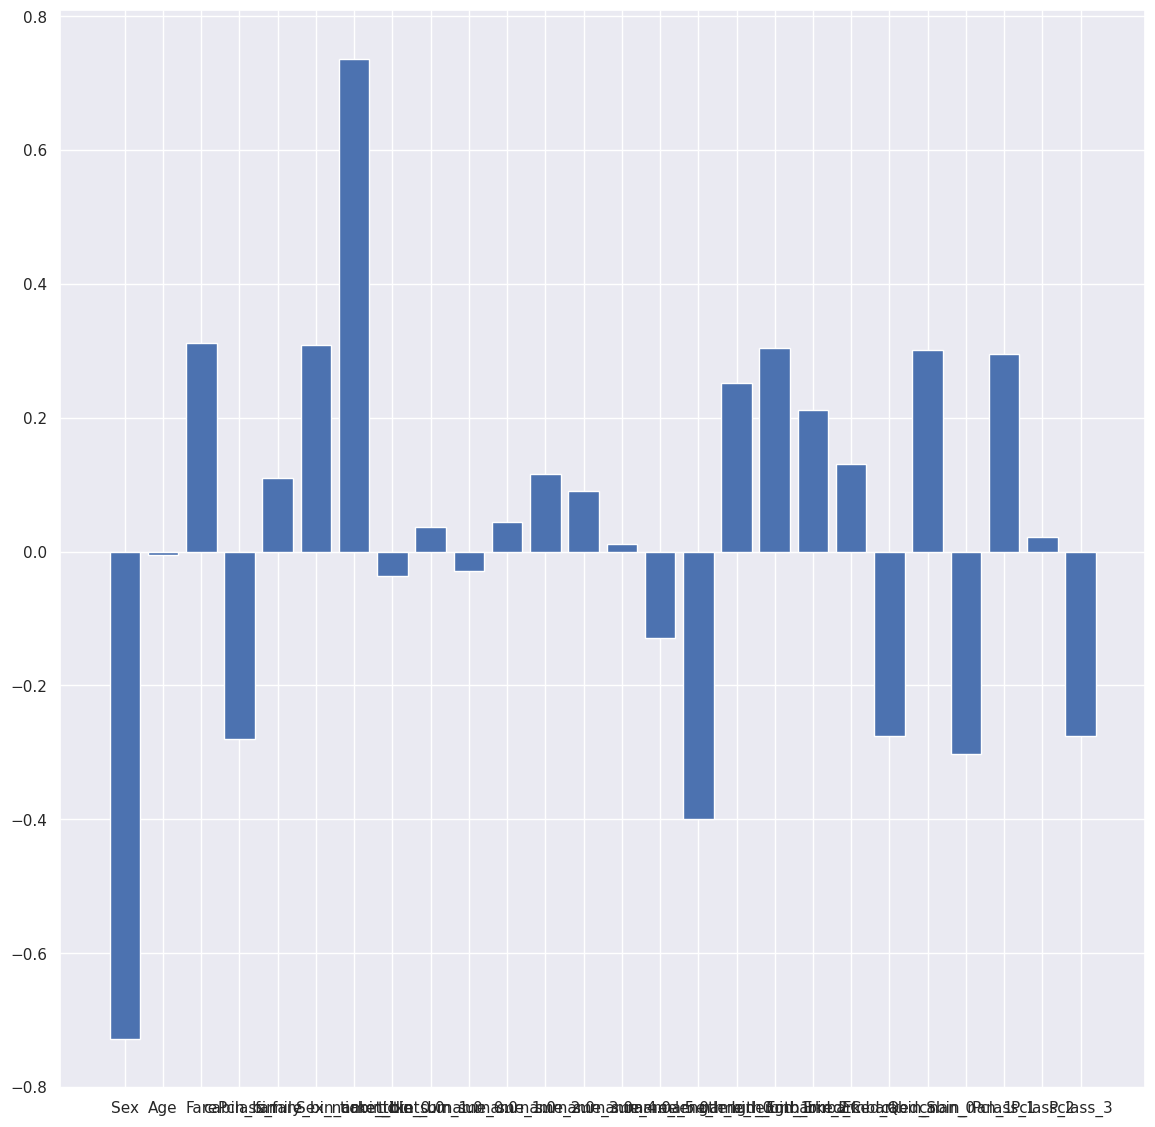

In [ ]:
plt.bar(dict(test.corrwith(submission["Survived"])).keys(), dict(test.corrwith(submission["Survived"])).values())

# Results:

- Submission #1 : Scored 0.57: Used only features Pclass  Sex       Age     SibSp  Parch      Fare  Embarked, and basic normalization + categorical encoding + RF with 500 estimators
- Submission #2: Scored 0.67 after dropping nan valued features while training + imputing test data with mean values
- Submission #3: Scored 0.75 after imputing nan values with the median of the feature
- Submission #4: Logistic GAM instead of RF improved score slightly (0.76)
- Submission #5: Scored 0.77 with RF(with optimized hyperparams) (Score improved to 0.772 w results of RF + twice weighted results of GAM)
- Submission #6: Scored 0.775 with feature ticket bin encoding and name title together inc accuracy to 0.775 +weighted GAM and RF prediction ~top 75% in Kaggle. Hmmm, lets see what else we can try.
- Added cabin_nan, accuracy dec
- => Features : [ Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, name_title] +RF (optimized) =>0.7799
- => Features : [Pclass  Sex     Age  Embarked  name_title  family] +RF (optimized) => 0.78468
- => Features : [Pclass  Sex     Age  Embarked  family] +RF (optimized) => 0.78708